# Code to filter and preprocess the genotype data and compute the principal components and genetic relatedness matrix prior to running the susceptibility GWAS association.

### Contains code at the bottom of the notebook for running the GWAS using GMMAT that was included with the initial publication submission. During revision, we switched to using SAIGE for the association to reduce false positives related to case-control number imbalance. The initial GWAS analysis based on GMMAT is kept in this notebook for completeness but see Run_GWAS_AllPhenotypes.ipynb for the actual association tested used in the manuscript. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
sys.path.append('../../code/gwas_analysis')
from gwas_plotting import manhattan, manhattan_fixwidth, qqplot
from gwas_utils import annotate_gwas_plink2
from IPython.display import display
import glob
from scipy.stats import chi2

In [40]:
tmpdir = '../../data/tmp/'
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)

gwasdir = os.path.join(tmpdir, 'GWAS')
if not os.path.exists(gwasdir):
    os.mkdir(gwasdir)
    
basedata = os.path.join(gwasdir, 'data')
if not os.path.exists(basedata):
    os.mkdir(basedata)
    
imputeddata = os.path.join(basedata, 'imputed')
if not os.path.exists(imputeddata):
    os.mkdir(imputeddata)
    
rawdata = os.path.join(basedata, 'raw')
if not os.path.exists(rawdata):
    os.mkdir(rawdata)

resdir = os.path.join(gwasdir, 'results_20230804')
if not os.path.exists(resdir):
    os.mkdir(resdir)

## Prepare Phenotypes

In [2]:
# each row is a genotyped sample, named by its IID. this table contains metadata we can use for phenotype definition
# and stratification
group_fn = 'gs://popgen-gwas/data/metadata/Annotated_GenotypedData/OmniH3Merged_PrePost2016_AggregatedLASVPhenotypes_20210829.tsv'
groups = pd.read_csv(group_fn, sep='\t')
groups.index = groups['#IID'].values

In [3]:
groups[['#IID', 'SEX', 'Epoch_Bin', 'Country', 'Age', 'CollectionEpoch']].head()

,#IID,SEX,Epoch_Bin,Country,Age,CollectionEpoch
WG0284565-DNA_A02_G-5231,WG0284565-DNA_A02_G-5231,2,1,1,38.0,Post2016
WG0284565-DNA_A03_G-5686,WG0284565-DNA_A03_G-5686,2,1,1,10.0,Post2016
WG0284565-DNA_A04_G-5690,WG0284565-DNA_A04_G-5690,1,1,1,16.0,Post2016
WG0284565-DNA_A05_G-5135,WG0284565-DNA_A05_G-5135,2,1,1,49.0,Post2016
WG0284565-DNA_A06_G-5045,WG0284565-DNA_A06_G-5045,2,1,1,24.0,Post2016


In [4]:
# phenotype definition
main_phenotype_data = groups[['#IID', 'SEX', 'Epoch_Bin', 'Country', 'Age', 'CollectionEpoch']] #what we care about in definition
main_phenotype_data['Full_Batch'] = groups['Batch']
main_phenotype_data['H3'] = groups['Batch'].replace({25:0, 26:0, 50:0, 1:1, 2:1}) #batch definition 
main_phenotype_data['Omni_25A'] = main_phenotype_data['Full_Batch'].replace({25:1, 1:0, 2:0, 26:0, 50:0})
main_phenotype_data['Omni_25B'] = main_phenotype_data['Full_Batch'].replace({25:0, 1:0, 2:0, 26:1, 50:0})
main_phenotype_data['Omni_25'] = main_phenotype_data['Full_Batch'].replace({25:1, 1:0, 2:0, 26:1, 50:0})
main_phenotype_data['Omni_5'] = main_phenotype_data['Full_Batch'].replace({25:0, 1:0, 2:0, 26:0, 50:1})
main_phenotype_data['Omni'] = main_phenotype_data['Full_Batch'].replace({25:1, 1:0, 2:0, 26:1, 50:1})

main_phenotype_data.head()

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,#IID,SEX,Epoch_Bin,Country,Age,CollectionEpoch,Full_Batch,H3,Omni_25A,Omni_25B,Omni_25,Omni_5,Omni
WG0284565-DNA_A02_G-5231,WG0284565-DNA_A02_G-5231,2,1,1,38.0,Post2016,1,1,0,0,0,0,0
WG0284565-DNA_A03_G-5686,WG0284565-DNA_A03_G-5686,2,1,1,10.0,Post2016,1,1,0,0,0,0,0
WG0284565-DNA_A04_G-5690,WG0284565-DNA_A04_G-5690,1,1,1,16.0,Post2016,1,1,0,0,0,0,0
WG0284565-DNA_A05_G-5135,WG0284565-DNA_A05_G-5135,2,1,1,49.0,Post2016,1,1,0,0,0,0,0
WG0284565-DNA_A06_G-5045,WG0284565-DNA_A06_G-5045,2,1,1,24.0,Post2016,1,1,0,0,0,0,0


In [5]:
main_phenotype_data['Full_Batch'].value_counts()

25    1755
1     1531
2     1310
26     540
50     419
Name: Full_Batch, dtype: int64

In [6]:
main_phenotype_data.iloc[:,6:].sum(axis=0)

Full_Batch    83016
H3             2841
Omni_25A       1755
Omni_25B        540
Omni_25        2295
Omni_5          419
Omni           2714
dtype: int64

In [7]:
p = 'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl' 
cases = ['Post2016_NG_LASV_ExactLVMatchqPCR2xPosOrSeqPos', 'Pre2016_NG_LASV_qPCR1xPos', 'Pre2016_NG_LASV_SeqPos'] 

#all the cases to be merged: Nigerians across batches who are determined to be positive by qPCR or sequencing
controls = ['Pre2016_NG_LASV_PopControl', 'Post2016_NG_LASV_PopControl']
# all the controls to be merged: Nigerians across batches serving as population controls, and qPCR- samples
main_phenotype_data[p] = -1 #null
for c in cases:
    main_phenotype_data.loc[groups.index[groups[c]], p] = 1 #1 for cases
for c in controls:
    main_phenotype_data.loc[groups.index[groups[c]], p] = 0 #1 for controls   
print(p)
print(main_phenotype_data[p].value_counts())

MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl
-1    3734
 0    1287
 1     534
Name: MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl, dtype: int64


/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
p = 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl' 

cases = ['Pre2016_SL_LASV_AgORSeqPos', 'Post2016_SL_LASV_AgPos'] 
#all the cases to be merged: SL across batches who are determined to be positive by Ag or sequencing
controls = ['Pre2016_SL_LASV_PopControl']
# all the controls to be merged: SL across batches serving as population controls

main_phenotype_data[p] = -1 #null
for c in cases:
    main_phenotype_data.loc[groups.index[groups[c]], p] = 1 #1 for cases
for c in controls:
    main_phenotype_data.loc[groups.index[groups[c]], p] = 0 #1 for controls   
print(p)
print(main_phenotype_data[p].value_counts())

MergeEpoch_SL_AgORSeqPos_Vs_PopControl
-1    4528
 0     867
 1     160
Name: MergeEpoch_SL_AgORSeqPos_Vs_PopControl, dtype: int64


/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
phenofn = os.path.join(gwasdir, '20220227_LASV_MergeEpoch_Susceptibility_Phenotypes.tsv')
print(phenofn)
main_phenotype_data.to_csv(phenofn, sep='\t', index=False)

../../data/tmp/GWAS/20220227_LASV_MergeEpoch_Susceptibility_Phenotypes.tsv


In [51]:
main_phenotype_data.loc[['WG0284582-DNA_B05_2028', 'WG0284565-DNA_C12_G-7167'], :]

,#IID,SEX,Epoch_Bin,Country,Age,CollectionEpoch,Full_Batch,H3,Omni_25A,Omni_25B,Omni_25,Omni_5,Omni,MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl,MergeEpoch_SL_AgORSeqPos_Vs_PopControl
WG0284582-DNA_B05_2028,WG0284582-DNA_B05_2028,1,1,0,36.0,Pre2016,1,1,0,0,0,0,0,1,-1
WG0284565-DNA_C12_G-7167,WG0284565-DNA_C12_G-7167,1,1,1,75.0,Post2016,1,1,0,0,0,0,0,-1,1


## Subset the raw data, run PCA, construct GRM for each phenotype

In [52]:
main_phenotype_data.head()

,#IID,SEX,Epoch_Bin,Country,Age,CollectionEpoch,Full_Batch,H3,Omni_25A,Omni_25B,Omni_25,Omni_5,Omni,MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl,MergeEpoch_SL_AgORSeqPos_Vs_PopControl
WG0284565-DNA_A02_G-5231,WG0284565-DNA_A02_G-5231,2,1,1,38.0,Post2016,1,1,0,0,0,0,0,-1,-1
WG0284565-DNA_A03_G-5686,WG0284565-DNA_A03_G-5686,2,1,1,10.0,Post2016,1,1,0,0,0,0,0,-1,-1
WG0284565-DNA_A04_G-5690,WG0284565-DNA_A04_G-5690,1,1,1,16.0,Post2016,1,1,0,0,0,0,0,-1,-1
WG0284565-DNA_A05_G-5135,WG0284565-DNA_A05_G-5135,2,1,1,49.0,Post2016,1,1,0,0,0,0,0,-1,-1
WG0284565-DNA_A06_G-5045,WG0284565-DNA_A06_G-5045,2,1,1,24.0,Post2016,1,1,0,0,0,0,0,-1,-1


In [53]:
pd.crosstab(main_phenotype_data['Age'].isnull(), main_phenotype_data['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'])

MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl,-1,0,1
Age,,,
False,3454,1284,521
True,280,3,13


In [54]:
pd.crosstab(main_phenotype_data['Age'].isnull(), main_phenotype_data['MergeEpoch_SL_AgORSeqPos_Vs_PopControl'])

MergeEpoch_SL_AgORSeqPos_Vs_PopControl,-1,0,1
Age,,,
False,4448,651,160
True,80,216,0


In [55]:
# phenotypes
phenotypes = ['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl',
             'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']
phenotypes

['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl',
 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']

In [56]:
main_phenotype_data.columns

Index(['#IID', 'SEX', 'Epoch_Bin', 'Country', 'Age', 'CollectionEpoch',
       'Full_Batch', 'H3', 'Omni_25A', 'Omni_25B', 'Omni_25', 'Omni_5', 'Omni',
       'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl',
       'MergeEpoch_SL_AgORSeqPos_Vs_PopControl'],
      dtype='object')

In [57]:
# define covariates to be used in GLMM
covarmap = {
            'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl':['SEX', 'PCs', 'H3'],
            'MergeEpoch_SL_AgORSeqPos_Vs_PopControl':['SEX', 'PCs', 'H3']
            }

In [58]:
# copy input plink files to local directory
cmd = 'gsutil -m cp gs://popgen-gwas/data/genotype/merge/Unimputed/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.* %s/' % rawdata
print(cmd)
!{cmd}

gsutil -m cp gs://popgen-gwas/data/genotype/merge/Unimputed/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.* ../../data/tmp/GWAS/data/raw/
Copying gs://popgen-gwas/data/genotype/merge/Unimputed/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.bed...
Copying gs://popgen-gwas/data/genotype/merge/Unimputed/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.bim...
Copying gs://popgen-gwas/data/genotype/merge/Unimputed/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.bed...
Copying gs://popgen-gwas/data/genotype/merge/Unimputed/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.bim...
Copying gs://popgen-gwas/data/genotype/merge/Unimputed/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.fam...
Copying gs://popgen-gwas/data/genotype/merge/Unimputed/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_

In [59]:
# specify the local directory where plink should look for input files
rawbase= '%s/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223' % rawdata
rawbase

'../../data/tmp/GWAS/data/raw/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223'

In [60]:
! gsutil cp gs://popgen-gwas/data/metadata/Annotated_GenotypedData/OmniH3Merged_PrePost2016.20210720.Geno_1e-1.filtBatchvars20210720.DupsToExclude.IIDonly.txt /home/sraju/data/tmp/plink/MergePrePost/

Copying gs://popgen-gwas/data/metadata/Annotated_GenotypedData/OmniH3Merged_PrePost2016.20210720.Geno_1e-1.filtBatchvars20210720.DupsToExclude.IIDonly.txt...
Skipping attempt to download to filename ending with slash                      
(/home/sraju/data/tmp/plink/MergePrePost/). This typically happens
when using gsutil to download from a subdirectory created by the Cloud
Console (https://cloud.google.com/console)

Operation completed over 1 objects/15.4 KiB.                                     


In [61]:
! gsutil cp gs://popgen-gwas/data/metadata/Annotated_GenotypedData/OmniH3Merged_PrePost2016.20210720.Geno_1e-1.filtBatchvars20210720.DupsToExclude.txt /home/sraju/data/tmp/plink/MergePrePost/

Copying gs://popgen-gwas/data/metadata/Annotated_GenotypedData/OmniH3Merged_PrePost2016.20210720.Geno_1e-1.filtBatchvars20210720.DupsToExclude.txt...
Skipping attempt to download to filename ending with slash                      
(/home/sraju/data/tmp/plink/MergePrePost/). This typically happens
when using gsutil to download from a subdirectory created by the Cloud
Console (https://cloud.google.com/console)

Operation completed over 1 objects/23.0 KiB.                                     


In [63]:
dupfiltfn_fam = '../../data/tmp/plink/MergePrePost/OmniH3Merged_PrePost2016.20210720.Geno_1e-1.filtBatchvars20210720.DupsToExclude.txt'
dupfiltfn = '../../data/tmp/plink/MergePrePost/OmniH3Merged_PrePost2016.20210720.Geno_1e-1.filtBatchvars20210720.DupsToExclude.IIDonly.txt'

fam = pd.read_csv(dupfiltfn_fam, sep='\t')
fam[['1']].to_csv(dupfiltfn, sep='\t', index=False, header=False)

In [64]:
cmd = 'plink2 --make-bed --bfile {inv} --out {inv}.deduped --remove {removefn} --keep-allele-order'.format(inv=rawbase, removefn=dupfiltfn_fam)
print(cmd)
!{cmd}

plink2 --make-bed --bfile ../../data/tmp/GWAS/data/raw/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223 --out ../../data/tmp/GWAS/data/raw/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped --remove ../../data/tmp/plink/MergePrePost/OmniH3Merged_PrePost2016.20210720.Geno_1e-1.filtBatchvars20210720.DupsToExclude.txt --keep-allele-order
PLINK v2.00a3LM 64-bit Intel (1 Jul 2021)      www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/GWAS/data/raw/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.log.
Options in effect:
  --bfile ../../data/tmp/GWAS/data/raw/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223
  --keep-allele-order
  --make-bed
  --out ../../data/tmp/GWAS/data/raw/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped
  --remove ../..

In [65]:
rawbase = '{inv}.deduped'.format(inv=rawbase)
print(rawbase)

../../data/tmp/GWAS/data/raw/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped


In [66]:
# parameters to be used in plink processing
maf = '1e-2' # minor allele frequency: the frequency at which the second most common allele occurs in a given population
#variants present at a frequency below the stated cutoff are removed
hwe = '1e-6' # Hardy-Weinberg equilibrium exact test p-value. variants that deviate enough to generate this low
#of a pval are excluded
mac = 25 # Min minor allele counts
geno = '5e-2'# variants with missing call rates exceeding the provided value
prune_maf = '5e-2'# only minor alleles occurring at at least this frequency are considered
prune_r2 = '5e-1' # pairs of variants with squared correlation greater than the threshold are noted, 
#and variants are greedily pruned from the window until no such pairs remain
relcutoff = '5e-2'# excludes one member of each pair of samples with observed genomic relatedness greater than the 
#given cutoff value

In [67]:
print(resdir)
print(phenotypes)

../../data/tmp/GWAS/results_20230804
['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl', 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']


In [69]:
praw_adats = []
run = True
for p in phenotypes:
    pdir = os.path.join(resdir, p)
    if not os.path.exists(pdir): os.mkdir(pdir)
    pdir_rawdata = os.path.join(pdir, 'raw_data')
    if not os.path.exists(pdir_rawdata): os.mkdir(pdir_rawdata)
    pdir_pca = os.path.join(pdir, 'pca')
    if not os.path.exists(pdir_pca): os.mkdir(pdir_pca)
    pdir_rel = os.path.join(pdir, 'rel')
    if not os.path.exists(pdir_rel): os.mkdir(pdir_rel)
    
    outfn = os.path.join(pdir_rawdata, rawbase.split('/')[-1]+'.{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.mac_{mac}'.format(p=p, maf=maf, hwe=hwe, geno=geno, mac=mac))
    praw_adats.append(outfn)
    
    ## Output samples with the current phenotype value to keep for subsequent calculations ##
    sampfn = os.path.join(pdir, 'samples.txt')
    if run:
        samples = main_phenotype_data.loc[main_phenotype_data[p]!=-1, '#IID']
        fam = pd.read_csv(rawbase+'.fam', sep='\t', header=None)
        fam.index = fam[1]
        samples = list(set(fam.index).intersection(samples))
        fam = fam.loc[samples, [0,1]]
        fam.to_csv(sampfn, sep='\t', index=False, header=False)

    ## Filter variants on MAF Geno and HWE, output plink2 fileset ##
    filt_cmd = 'plink2 --make-pgen --bfile {inv} --keep {samples} --keep-allele-order --maf {maf} --hwe {hwe} --geno {geno} --mac {mac} --out {out}'.format(inv=rawbase, samples=sampfn, out=outfn, maf=maf, hwe=hwe, geno=geno, mac=mac)
    print(filt_cmd)
    if run:
        !{filt_cmd}
    print('--------------------------\n\n\n\n\n\n\n')

    ## Output plink1 fileset from plink2 fileset ##
    bed_cmd = 'plink2 --make-bed --pfile {inv} --out {inv} --keep-allele-order'.format(inv=outfn)
    print(bed_cmd)
    if run:
        !{bed_cmd}
    print('--------------------------\n\n\n\n\n\n\n')


    '''    
    ## Compute an LD pruned variant set with a given MAF ##
    prunefn = os.path.join(pdir_pca, 'prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    prune_cmd = 'plink2 --pfile {adat} --out {adatout} --indep-pairwise 1000kb 1 {prune_r2} --maf {prune_maf}'.format(adat=outfn, adatout=prunefn, prune_r2=prune_r2, prune_maf=prune_maf)
    print(prune_cmd)
    !{prune_cmd}
    print('--------------------------\n\n\n\n\n\n\n')
    '''
    
    ## Run PCA without the pruned variant set ##
    pcafn = os.path.join(pdir_pca, os.path.basename(outfn))
    #pca_cmd = 'plink2 --pfile {adat} --out {adatout} --pca 20 --extract {adatout}.prune.in'.format(adat=outfn, adatout=prunefn)
    pca_cmd = 'plink2 --pfile {adat} --out {adatout} --pca 20'.format(adat=outfn, adatout=pcafn)
    print(pca_cmd)
    if run:
        !{pca_cmd}

    print('--------------------------\n\n\n\n\n\n\n')

    ## Compute GRM without the pruned variant set ## 
    #relbase = os.path.join(pdir_rel, 'prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    relbase = os.path.join(pdir_rel, os.path.basename(outfn))
    #rel_cmd = 'plink2 --make-rel square --pfile {adat} --out {adatout} --extract {prune}.prune.in'.format(adat=outfn, adatout=relbase, prune=prunefn)
    rel_cmd = 'plink2 --make-rel square --pfile {adat} --out {adatout}'.format(adat=outfn, adatout=relbase)
    print(rel_cmd)
    if run:
        !{rel_cmd}
    print('--------------------------\n\n\n\n\n\n\n')

    if run:
        ## Output a text file of the GRM containing sample IDs as column and row labels ## 
        relid = pd.read_csv(relbase+'.rel.id', sep='\t').iloc[:,1]
        rel = pd.read_csv(relbase+'.rel', header=None, sep='\t')
        rel.index = relid
        rel.columns = relid
        rel.to_csv(relbase+'.rel.withids.tsv', sep='\t')

    ## Output a binary GRM file ## 
    #rel_cmd = 'plink2 --make-grm-bin --pfile {adat} --out {adatout} --extract {prune}.prune.in'.format(adat=outfn, adatout=relbase, prune=prunefn)
    rel_cmd = 'plink2 --make-grm-bin --pfile {adat} --out {adatout}'.format(adat=outfn, adatout=relbase)
    print(rel_cmd)
    if run:
        !{rel_cmd}
        
    print('--------------------------\n\n\n\n\n\n\n')

    ## Output a set of unrelated samples (GRM value < a given threswhold) ## 
    unrelatedsfn = os.path.join(pdir_rel, 'unrelated_individuals.rel_{relcutoff}.txt'.format(relcutoff=relcutoff))
    get_unrelateds_cmd = 'plink --rel-cutoff {relcutoff} --grm-bin {rel} --out {out}'.format(rel=relbase, out=unrelatedsfn, relcutoff=relcutoff)
    print(get_unrelateds_cmd)
    if run:
        !{get_unrelateds_cmd}

    print('--------------------------\n\n\n\n\n\n\n')

plink2 --make-pgen --bfile ../../data/tmp/GWAS/data/raw/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped --keep ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/samples.txt --keep-allele-order --maf 1e-2 --hwe 1e-6 --geno 5e-2 --mac 25 --out ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25
PLINK v2.00a3LM 64-bit Intel (1 Jul 2021)      www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xP

## Calculate PCs from unrelated individuals and project the full sample set onto this PC space. 
This allows signals that are dominated by close relatives (e.g. tribe) to become more visible 

In [71]:
run = True

for (i,p) in enumerate(phenotypes):
    ## Filter variants on MAF Geno and HWE, output plink2 fileset ##
    pdir = os.path.join(resdir, p)
    pdir_rawdata = os.path.join(pdir, 'raw_data')
    pdir_pca = os.path.join(pdir, 'pca')
    pdir_rel = os.path.join(pdir, 'rel')    
    unrelatedsfn = os.path.join(pdir_rel, 'unrelated_individuals.rel_{relcutoff}.txt.grm.id'.format(relcutoff=relcutoff))
    outfn = praw_adats[i] + '.unrelated'
    filt_cmd = 'plink2 --make-pgen --pfile {inv} --keep {samples} --keep-allele-order --maf {maf} --hwe {hwe} --geno {geno} --mac {mac} --out {out}'.format(inv=praw_adats[i], samples=unrelatedsfn, out=outfn, maf=maf, hwe=hwe, geno=geno, mac=mac)
    print(filt_cmd)
    if run:
        !{filt_cmd}
    
    '''
    ## Compute an LD pruned variant set with a given MAF ##
    prunefn = os.path.join(pdir_pca, 'unrelated.prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    prune_cmd = 'plink2 --pfile {adat} --out {adatout} --indep-pairwise 1000kb 1 {prune_r2} --maf {prune_maf}'.format(adat=outfn, adatout=prunefn, prune_r2=prune_r2, prune_maf=prune_maf)
    print(prune_cmd)
    !{prune_cmd}
    '''

    ## Run PCA with the pruned variant set ##
    #pca_cmd = 'plink2 --pfile {adat} --out {adatout} --freq --pca 20 biallelic-var-wts --extract {adatout}.prune.in'.format(adat=outfn, adatout=prunefn)
    pcafn = os.path.join(pdir_pca, os.path.basename(outfn))
    pca_cmd = 'plink2 --pfile {adat} --out {adatout} --freq --pca 20 biallelic-var-wts'.format(adat=outfn, adatout=pcafn)
    print(pca_cmd)
    if run:
        !{pca_cmd}
    
    '''
    CODE FROM https://groups.google.com/g/plink2-users/c/W6DL5-hs_Q4?pli=1
    Step 1: Export allele frequencies and PCA variant weights from your reference dataset.  E.g.
      plink2 --bfile hapmap --freq --pca var-wts --out pca_hapmap

    Step 2: Use --score to compute the necessary dot products with the variant weights.  E.g.
      plink2 --bfile mydata --read-freq pca_hapmap.afreq --score pca_hapmap.eigenvec.var 2 3 header-read no-mean-imputation variance-normalize --score-col-nums 5-14 --out pca_proj_mydata
    '''
    
    full_fn = praw_adats[i]
    #projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated.prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated')
    #project_cmd = 'plink2 --bfile {full} --read-freq {adatout}.afreq --score {adatout}.eigenvec.var 2 3 header-read no-mean-imputation variance-normalize --score-col-nums 5-14 --out {proj}'.format(full=full_fn, adatout=prunefn, proj=projectfn)
    project_cmd = 'plink2 --pfile {full} --read-freq {adatout}.afreq --score {adatout}.eigenvec.var 2 3 header-read no-mean-imputation variance-normalize --score-col-nums 5-14 --out {proj}'.format(full=full_fn, adatout=pcafn, proj=projectfn)
    print(project_cmd)
    if run:
        !{project_cmd}
    
    ## Load projection results and rename columns
    if run:
        projection = pd.read_csv(projectfn + '.sscore', sep='\t')
        cols = ['PC1_AVG', 'PC2_AVG', 'PC3_AVG', 'PC4_AVG', 'PC5_AVG', 'PC6_AVG',
           'PC7_AVG', 'PC8_AVG', 'PC9_AVG', 'PC10_AVG']
        rename = {c:c.split('_')[0] for c in cols}
        projection = projection.rename(columns=rename)
        projection.index = projection['IID']

        ## Scale by 1/(sqrt(eigenval) / -2) to convert to same scale as the original PCs
        #unrelated_eigenval = pd.read_csv(prunefn + '.eigenval', sep='\t', header=None)
        unrelated_eigenval = pd.read_csv(pcafn + '.eigenval', sep='\t', header=None)
        scale_factor = 1/(np.sqrt(unrelated_eigenval[0])/-2)
        scale_factor.index = ['PC%d' % (i+1) for i in scale_factor.index]
        for c in scale_factor.index[:10]:
            projection[c] = projection[c]*scale_factor[c]
        
        ## Compare to the original PCs as a sanity check
        #unrelated_eigenvec = pd.read_csv(prunefn + '.eigenvec', sep='\t')
        unrelated_eigenvec = pd.read_csv(pcafn + '.eigenvec', sep='\t')

        unrelated_eigenvec.index = unrelated_eigenvec['IID']
        display(
            pd.concat([unrelated_eigenvec['PC1'],
                   projection.loc[unrelated_eigenvec.index, 'PC1']], axis=1).head()
        )

        display(
            pd.concat([unrelated_eigenvec['PC2'],
                   projection.loc[unrelated_eigenvec.index, 'PC2']], axis=1).head()
        )
    
        ## Output projected rescaled PCs
        projection.to_csv(projectfn + '.PCs.tsv', sep='\t', index=False)

plink2 --make-pgen --pfile ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25 --keep ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/rel/unrelated_individuals.rel_5e-2.txt.grm.id --keep-allele-order --maf 1e-2 --hwe 1e-6 --geno 5e-2 --mac 25 --out ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.unrelated
PLINK v2.00a3LM 64-bit Intel (1 Jul 2021)      www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/

,PC1,PC1
IID,,
WG0284582-DNA_A05_SM-87W5V,-0.024686,-0.024674
WG0284582-DNA_D05_SM-45CMW,0.024264,0.024235
WG0284582-DNA_H02_SM-45HM6,-0.051384,-0.051347
WG0284584-DNA_B11_ISTH-CASE-2760,0.023857,0.023833
WG0284584-DNA_C11_ISTH-CASE-878/LV/14,-0.018529,-0.018520


,PC2,PC2
IID,,
WG0284582-DNA_A05_SM-87W5V,0.009241,0.009230
WG0284582-DNA_D05_SM-45CMW,-0.015674,-0.015661
WG0284582-DNA_H02_SM-45HM6,0.024887,0.024872
WG0284584-DNA_B11_ISTH-CASE-2760,-0.015033,-0.015021
WG0284584-DNA_C11_ISTH-CASE-878/LV/14,-0.018424,-0.018422


plink2 --make-pgen --pfile ../../data/tmp/GWAS/results_20230804/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25 --keep ../../data/tmp/GWAS/results_20230804/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/rel/unrelated_individuals.rel_5e-2.txt.grm.id --keep-allele-order --maf 1e-2 --hwe 1e-6 --geno 5e-2 --mac 25 --out ../../data/tmp/GWAS/results_20230804/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.unrelated
PLINK v2.00a3LM 64-bit Intel (1 Jul 2021)      www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/GWAS/results_20230804/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2

,PC1,PC1
IID,,
WG0284565-DNA_A08_G-7030,-0.016640,-0.016634
WG0284565-DNA_A09_G-7022,0.008016,0.008008
WG0284565-DNA_B08_G-7260,0.018129,0.018119
WG0284565-DNA_B10_G-7140,-0.027366,-0.027352
WG0284565-DNA_E08_G-6835,-0.013464,-0.013455


,PC2,PC2
IID,,
WG0284565-DNA_A08_G-7030,-0.045074,-0.045054
WG0284565-DNA_A09_G-7022,-0.024089,-0.024076
WG0284565-DNA_B08_G-7260,0.004892,0.004889
WG0284565-DNA_B10_G-7140,-0.048299,-0.048273
WG0284565-DNA_E08_G-6835,-0.004986,-0.004985


Text(0, 0.5, 'Porjected PC10 score\nfor unrelateds')

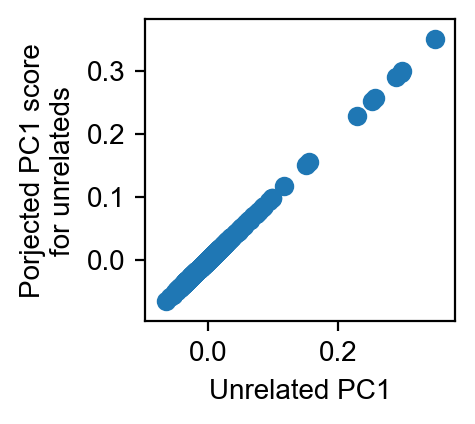

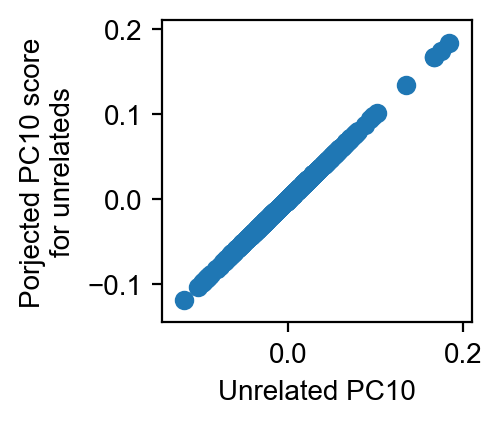

In [72]:
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200)
ax.scatter(unrelated_eigenvec['PC1'], projection.loc[unrelated_eigenvec.index, 'PC1'])
ax.set_xlabel('Unrelated PC1')
ax.set_ylabel('Porjected PC1 score\nfor unrelateds')
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200)
ax.scatter(unrelated_eigenvec['PC10'], projection.loc[unrelated_eigenvec.index, 'PC10'])
ax.set_xlabel('Unrelated PC10')
ax.set_ylabel('Porjected PC10 score\nfor unrelateds')

## Plot the principal components stratified by case/control status for each phenotype

In [73]:
phenotypes

['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl',
 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']

In [74]:
# how many PCs to consider
# we are choosing 7 based on where the elbows occur on the the skree plots below
num_pcs = {'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl':6,
          'MergeEpoch_SL_AgORSeqPos_Vs_PopControl':6}

In [75]:
# phenotypes
phenotypes = ['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl',
 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']

In [76]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

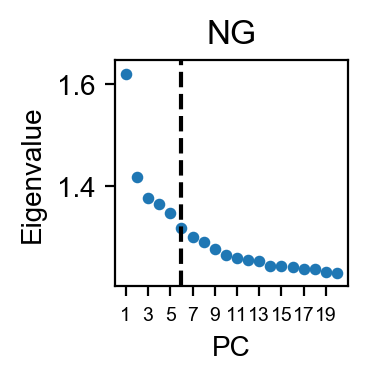

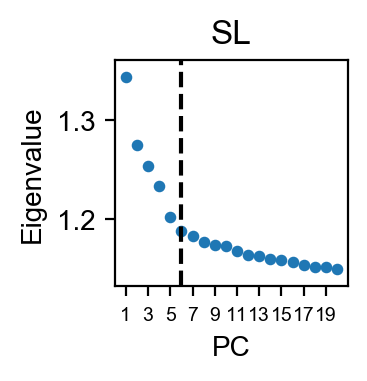

In [77]:
cmap = {0:'b', 1:'r'}
labmap = {0:'control', 1:'case'}
batchmap = {25:'r', 26:'b', 1:'g', 2:'g', 50:'y'}
for (i,p) in enumerate(phenotypes):
    ## Filter variants on MAF Geno and HWE, output plink2 fileset ##
    pdir = os.path.join(resdir, p)
    pdir_pca = os.path.join(pdir, 'pca')
    #prunefn = os.path.join(pdir_pca, 'unrelated.prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    outfn = praw_adats[i] + '.unrelated'
    pcafn = os.path.join(pdir_pca, os.path.basename(outfn))
    
    eigfn = pcafn + '.eigenval'
    eigenvals = pd.read_csv(eigfn, header=None)[0]
    
    (fig,ax) = plt.subplots(1,1, figsize=(1.5,1.5), dpi=200)
    ax.scatter(np.arange(1,len(eigenvals)+1), eigenvals, s=10)
    ax.set_xlabel('PC')
    ax.set_ylabel('Eigenvalue')
    ax.set_xticks(np.arange(1,21, step = 2))
    ax.set_xticklabels(np.arange(1,21, step = 2), fontsize=7)

    #ax.set_title(p)
    ylim = ax.get_ylim()
    ax.vlines(x=num_pcs[p], ymin=ylim[0], ymax=ylim[1], linestyle='--')
    ax.set_ylim(ylim)    
    ax.set_title(p.split('_')[1])
    plt.savefig('../../figures/PCA_UnrelatedProjection_Skree_%s.pdf' % p.split('_')[1], bbox_inches='tight')
    plt.savefig('../../figures/PCA_UnrelatedProjection_Skree_%s.png' % p.split('_')[1], bbox_inches='tight')

(1598, 20)
(921, 20)


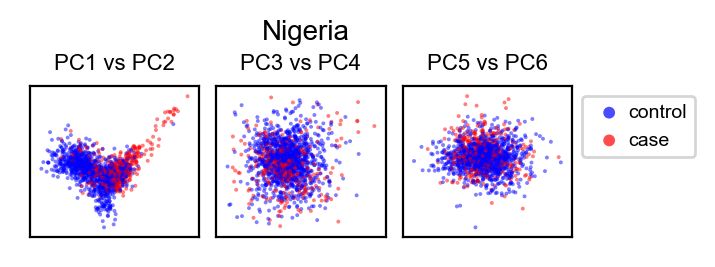

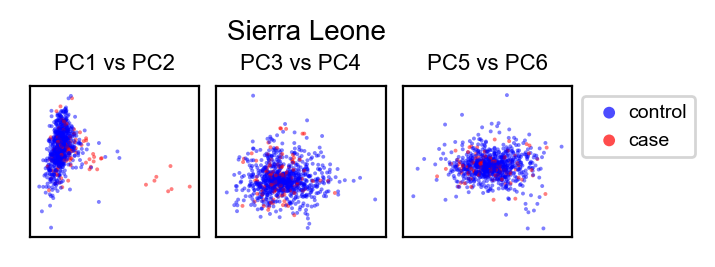

In [78]:
cmap = {0:'b', 1:'r'}
labmap = {0:'control', 1:'case'}
batchmap = {25:'r', 26:'b', 1:'g', 2:'g', 50:'y'}
fullmap = {'NG':'Nigeria', 'SL':'Sierra Leone'}
for (i,p) in enumerate(phenotypes):
    ## Filter variants on MAF Geno and HWE, output plink2 fileset ##
    pdir = os.path.join(resdir, p)
    pdir_pca = os.path.join(pdir, 'pca')
    #prunefn = os.path.join(pdir_pca, 'unrelated.prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated.PCs.tsv'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    pcs = pd.read_csv(projectfn, sep='\t')
    
    pcs_merged = pd.merge(left=pcs, right=main_phenotype_data[['#IID', p, 'H3', 'Full_Batch']], left_on='IID', right_on='#IID', how='left')
    pcs_merged['color'] = pcs_merged[p].replace(cmap)
    print(pcs_merged.shape)

    (fig,axes) = plt.subplots(1,3, figsize=(3.5,1), dpi=200, gridspec_kw={'wspace':.1})
    axes = axes.ravel()
    for (num,firstpc) in enumerate(range(1,7, 2)):
        pc1 = 'PC%d' % firstpc
        pc2 = 'PC%d' % (firstpc+1)   
        
        for (k,g) in pcs_merged.groupby(p):
            axes[num].scatter([], [], color=cmap[k], 
                                  s=8, edgecolor='None', alpha=.7, label=labmap[k])                                 

        order = np.random.permutation(pcs_merged.shape[0])
        Z = pcs_merged.iloc[order, :]
        #Z = pcs_merged.sort_values(by=p, ascending=True)
        axes[num].scatter(Z.loc[:,pc1], Z.loc[:,pc2],
                          c=Z['color'], s=2, edgecolor='None', alpha=.5)     
            
            
        xlim = axes[num].get_xlim()
        ylim = axes[num].get_ylim()
        xpos = [xlim[0] + (xlim[1]-xlim[0]) * .25, xlim[0] + (xlim[1]-xlim[0]) * .75]
        ypos = [ylim[0] + (ylim[1]-ylim[0]) * .25, ylim[0] + (ylim[1]-ylim[0]) * .75]

        axes[num].set_xticks([])
        axes[num].set_yticks([]) 
        #axes[num].set_xticks(xpos)
        #axes[num].set_yticks(ypos)        
        #axes[num].set_xticklabels(['%.1f' % x for x in xpos], fontsize=6)        
        #axes[num].set_yticklabels(['%.1f' % x for x in ypos], fontsize=6)                
        #axes[num].set_xlabel(pc1, fontsize=7, labelpad=-.5)
        #axes[num].set_ylabel(pc2, fontsize=7, labelpad=-.5)
        axes[num].set_title('%s vs %s' % (pc1, pc2), fontsize=8) 

    axes[2].legend(bbox_to_anchor=(1,1), fontsize=7, markerscale=1.5, handletextpad=0)
    plt.figtext(.52, 1.15, fullmap[p.split('_')[1]], va='center', ha='center')
    plt.savefig('../../figures/PCA_UnrelatedProjection_SusceptibilityCaseStatus_PC1-6_%s.pdf' % p.split('_')[1], bbox_inches='tight')
    plt.savefig('../../figures/PCA_UnrelatedProjection_SusceptibilityCaseStatus_PC1-6_%s.png' % p.split('_')[1], bbox_inches='tight')

(1598, 20)
(921, 20)


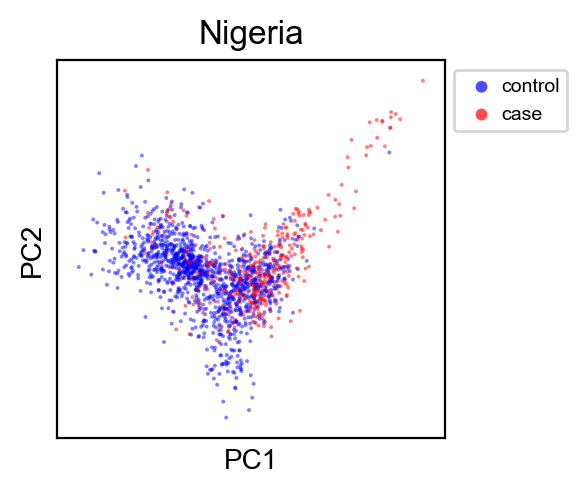

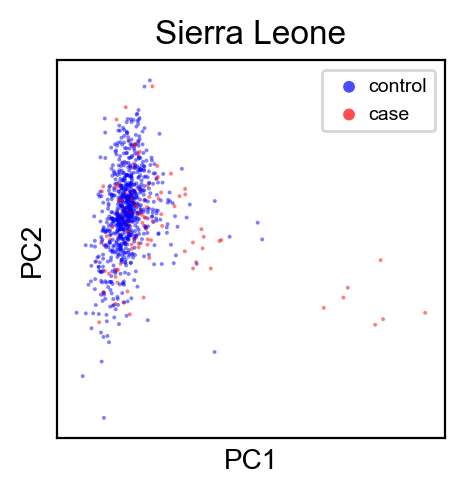

In [79]:
cmap = {0:'b', 1:'r'}
labmap = {0:'control', 1:'case'}
batchmap = {25:'r', 26:'b', 1:'g', 2:'g', 50:'y'}
fullmap = {'NG':'Nigeria', 'SL':'Sierra Leone'}
for (i,p) in enumerate(phenotypes):
    ## Filter variants on MAF Geno and HWE, output plink2 fileset ##
    pdir = os.path.join(resdir, p)
    pdir_pca = os.path.join(pdir, 'pca')
    #prunefn = os.path.join(pdir_pca, 'unrelated.prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated.PCs.tsv'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    pcs = pd.read_csv(projectfn, sep='\t')
    
    pcs_merged = pd.merge(left=pcs, right=main_phenotype_data[['#IID', p, 'H3', 'Full_Batch']], left_on='IID', right_on='#IID', how='left')
    pcs_merged['color'] = pcs_merged[p].replace(cmap)
    print(pcs_merged.shape)

    (fig,ax) = plt.subplots(1,1, figsize=(2.5,2.5), dpi=200, gridspec_kw={'wspace':.1})
    axes = axes.ravel()
    pc1 = 'PC1'
    pc2 = 'PC2'
        
    for (k,g) in pcs_merged.groupby(p):
        ax.scatter([], [], color=cmap[k], 
                                  s=8, edgecolor='None', alpha=.7, label=labmap[k])                                 

    order = np.random.permutation(pcs_merged.shape[0])
    Z = pcs_merged.iloc[order, :]
    ax.scatter(Z.loc[:,pc1], Z.loc[:,pc2],
                          c=Z['color'], s=2, edgecolor='None', alpha=.5)     
            
            
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xpos = [xlim[0] + (xlim[1]-xlim[0]) * .25, xlim[0] + (xlim[1]-xlim[0]) * .75]
    ypos = [ylim[0] + (ylim[1]-ylim[0]) * .25, ylim[0] + (ylim[1]-ylim[0]) * .75]

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    
    ax.set_title(fullmap[p.split('_')[1]]) 
    ax.legend(bbox_to_anchor=(1,1), fontsize=7, markerscale=1.5, handletextpad=0)
    plt.savefig('../../figures/PCA_UnrelatedProjection_SusceptibilityCaseStatus_PC1-2_%s.pdf' % p.split('_')[1], bbox_inches='tight')
    plt.savefig('../../figures/PCA_UnrelatedProjection_SusceptibilityCaseStatus_PC1-2_%s.png' % p.split('_')[1], bbox_inches='tight')

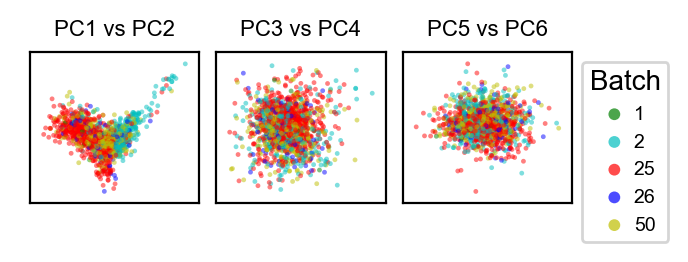

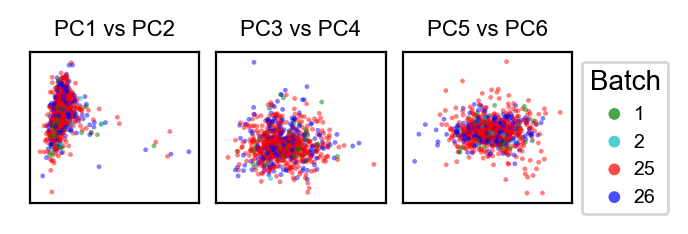

In [80]:
cmap = {0:'b', 1:'r'}
labmap = {0:'control', 1:'case'}
batchmap = {25:'r', 26:'b', 1:'g', 2:'c', 50:'y'}
fullmap = {'NG':'Nigeria', 'SL':'Sierra Leone'}
for (i,p) in enumerate(phenotypes):
    ## Filter variants on MAF Geno and HWE, output plink2 fileset ##
    pdir = os.path.join(resdir, p)
    pdir_pca = os.path.join(pdir, 'pca')
    #prunefn = os.path.join(pdir_pca, 'unrelated.prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated.PCs.tsv'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    pcs = pd.read_csv(projectfn, sep='\t')
    
    pcs_merged = pd.merge(left=pcs, right=main_phenotype_data[['#IID', p, 'H3', 'Full_Batch']], left_on='IID', right_on='#IID', how='left')
    pcs_merged['color'] = pcs_merged[p].replace(cmap)

    (fig,axes) = plt.subplots(1,3, figsize=(3.5,1), dpi=200, gridspec_kw={'wspace':.1})
    axes = axes.ravel()
    for (num,firstpc) in enumerate(range(1,7, 2)):
        pc1 = 'PC%d' % firstpc
        pc2 = 'PC%d' % (firstpc+1)   
        
        for (k,g) in pcs_merged.groupby('Full_Batch'):
            axes[num].scatter([], [], color=batchmap[k], 
                                  s=8, edgecolor='None', alpha=.7, label=k)                                 

        order = np.random.permutation(pcs_merged.shape[0])
        Z = pcs_merged.iloc[order, :]
        #Z = pcs_merged.sort_values(by=p, ascending=False)
        Z['color'] = Z['Full_Batch'].replace(batchmap)
        axes[num].scatter(Z.loc[:,pc1], Z.loc[:,pc2],
                          c=Z['color'], s=3, edgecolor='None', alpha=.5)     
            
            
        xlim = axes[num].get_xlim()
        ylim = axes[num].get_ylim()
        xpos = [xlim[0] + (xlim[1]-xlim[0]) * .25, xlim[0] + (xlim[1]-xlim[0]) * .75]
        ypos = [ylim[0] + (ylim[1]-ylim[0]) * .25, ylim[0] + (ylim[1]-ylim[0]) * .75]

        axes[num].set_xticks([])
        axes[num].set_yticks([]) 
        #axes[num].set_xticks(xpos)
        #axes[num].set_yticks(ypos)        
        #axes[num].set_xticklabels(['%.1f' % x for x in xpos], fontsize=6)        
        #axes[num].set_yticklabels(['%.1f' % x for x in ypos], fontsize=6)                
        #axes[num].set_xlabel(pc1, fontsize=7, labelpad=-.5)
        #axes[num].set_ylabel(pc2, fontsize=7, labelpad=-.5)
        axes[num].set_title('%s vs %s' % (pc1, pc2), fontsize=8) 

    axes[2].legend(bbox_to_anchor=(1,1), fontsize=7, markerscale=1.5, handletextpad=0, title='Batch')


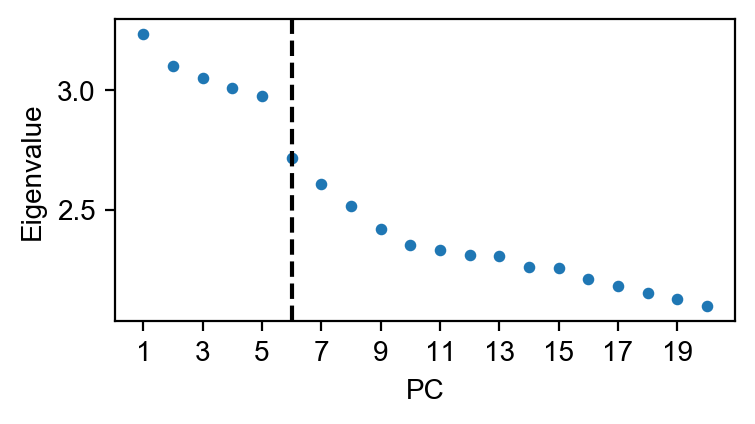

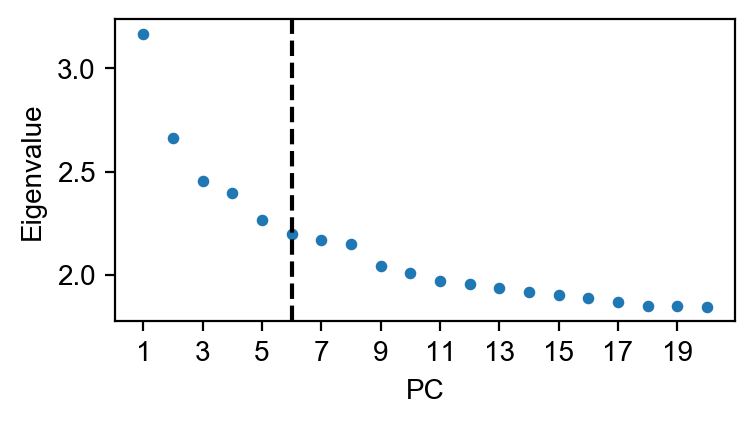

In [81]:
# update with
# 1. Manageable titles
for (i,p) in enumerate(phenotypes):
    pdir = os.path.join(resdir, p)
    pdir_pca = os.path.join(pdir, 'pca')
    eigfn = os.path.join(pdir_pca, os.path.basename(praw_adats[i]) + '.eigenval')
    #eigfn = os.path.join(pdir_pca, 'prune.ld_{prune_r2}.maf_{prune_maf}.eigenval'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    eigenvals = pd.read_csv(eigfn, header=None)[0]
    
    
    
    (fig,ax) = plt.subplots(1,1, figsize=(4,2), dpi=200)
    ax.scatter(np.arange(1,len(eigenvals)+1), eigenvals, s=10)
    ax.set_xlabel('PC')
    ax.set_ylabel('Eigenvalue')
    ax.set_xticks(np.arange(1,21, step = 2))
    #ax.set_title(p)
    ylim = ax.get_ylim()
    ax.vlines(x=num_pcs[p], ymin=ylim[0], ymax=ylim[1], linestyle='--')
    ax.set_ylim(ylim)
    #plt.savefig("/home/sraju/analysis_20200629/GWAS/20211007_full_gwas_figures/" + p + "_skree.png",
    #           bbox_inches = 'tight')

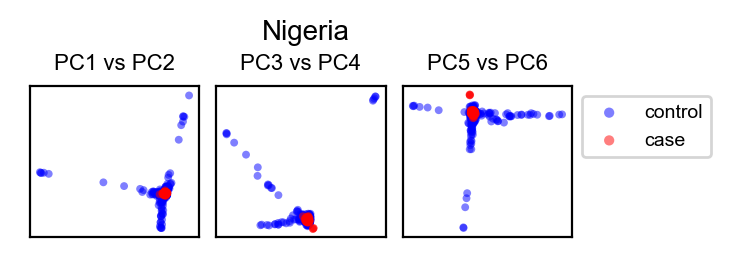

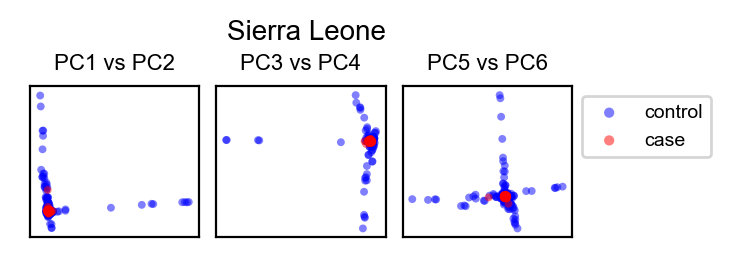

In [82]:
# the PCA plots show us internal relatedness structure. we do this to determine whether case/control status is
# confounded by family structure
# for instance, consider a scenario in which your case group contains a particular family with a set of specific 
#variants unrelated to disease
# you would find that these variants are overrepresented in the case group, and could erroneously conclude that this
# genomic region is associated with the case, when really it just arises due to family structure
# plotting the PCA and coloring by case/control status helps determine if this is the case

cmap = {0:'b', 1:'r'}
labmap = {0:'control', 1:'case'}
pcares = {}
for (i,p) in enumerate(phenotypes):
    pdir = os.path.join(resdir, p)
    pdir_pca = os.path.join(pdir, 'pca')
    #eigfn = os.path.join(pdir_pca, 'prune.ld_{prune_r2}.maf_{prune_maf}.eigenvec'.format(prune_r2=prune_r2, prune_maf=prune_maf))    
    eigfn = os.path.join(pdir_pca, os.path.basename(praw_adats[i]) + '.eigenvec')
    eigenvecs = pd.read_csv(eigfn, sep='\t')
    eigenvecs_merged = pd.merge(left=eigenvecs, right=main_phenotype_data[['#IID', p]], left_on='IID', right_on='#IID', how='left')
    (fig,axes) = plt.subplots(1,3, figsize=(3.5,1), dpi=200, gridspec_kw={'wspace':.1})
    axes = axes.ravel()
    for (num,firstpc) in enumerate(range(1,7, 2)):
        pc1 = 'PC%d' % firstpc
        pc2 = 'PC%d' % (firstpc+1)
        
        for val in range(2):
            ind = eigenvecs_merged[p]==val
            axes[num].scatter(eigenvecs_merged.loc[ind,pc1], eigenvecs_merged.loc[ind,pc2],
                          color=cmap[val], label=labmap[val], s=8, edgecolor='None', alpha=.5)

            
            
        axes[num].set_xticks([])
        axes[num].set_yticks([]) 
        axes[num].set_title('%s vs %s' % (pc1, pc2), fontsize=8) 
        
        
    axes[2].legend(bbox_to_anchor=(1,1), fontsize=7, markerscale=1.3)
    pcares[p] = eigenvecs_merged
    plt.figtext(.52, 1.15, fullmap[p.split('_')[1]], va='center', ha='center')
    #plt.savefig('../../figures/PCA_WithRelateds_SusceptibilityCaseStatus_PC1-6_%s.pdf' % p.split('_')[1], bbox_inches='tight')
    #plt.savefig('../../figures/PCA_WithRelateds_SusceptibilityCaseStatus_PC1-6_%s.png' % p.split('_')[1], bbox_inches='tight')

## Double check no duplicates

In [84]:
for p in phenotypes:
    pdir = os.path.join(resdir, p)
    pdir_rel = os.path.join(pdir, 'rel')
    #relbase = os.path.join(pdir_rel, 'prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    outfn = os.path.join(pdir_rawdata, rawbase.split('/')[-1]+'.{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.mac_{mac}'.format(p=p, maf=maf, hwe=hwe, geno=geno, mac=mac))
    relbase = os.path.join(pdir_rel, os.path.basename(outfn))

    rel = pd.read_csv(relbase+'.rel.withids.tsv', sep='\t', index_col=0)
    for i in rel.index:
        rel.at[i,i] = np.nan # nan at the diagonal because this is the same individual
        
    print(p)
    display(rel.max(axis=1).sort_values(ascending=False).head(20))

MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl


IID
WG0341168-DNA_C02_0142-LV-18    0.594766
WG0341185-DNA_H01_0065-LV-18    0.594766
Winter2013_F-NG-C-37C           0.562580
March2012_F-NG-C-2C             0.562580
Winter2013_SM-298DQ             0.558612
Fall2013_SM-3KQHC               0.558612
July2014NG_SM-4XBRC             0.556696
July2014NG_SM-4XBRE             0.556696
March2012_SM-2985G              0.546787
March2012_SM-29862              0.546787
Fall2013_SM-2982C               0.546149
Fall2013_SM-29824               0.546149
Fall2013_SM-298A9               0.544062
March2012_SM-2984E              0.544062
July2014NG_SM-4XBRL             0.541001
Winter2013_F-NG-NC-151F         0.541001
March2012_SM-2983I              0.540351
Winter2013_F-NG-NC-219M         0.540351
March2012_SM-298AM              0.537712
March2012_SM-2984B              0.537712
dtype: float64

MergeEpoch_SL_AgORSeqPos_Vs_PopControl


IID
July2014SL_SM-299L2    0.581799
July2014SL_SM-299MD    0.581799
Winter2013_SM-3KSF3    0.564167
Winter2013_SM-3KSDO    0.564167
Winter2013_SM-299PU    0.546507
Winter2013_SM-299Q8    0.546507
Winter2013_F-SL-1F     0.543859
Winter2013_F-SL-59F    0.543859
Winter2014_C-0426_1    0.534014
Winter2014_C-0430_1    0.534014
Winter2014_C-0641_1    0.530553
Winter2014_C-0635_1    0.530553
July2014SL_SM-299NV    0.528371
Winter2013_SM-3KSEG    0.524544
July2014SL_SM-299M4    0.524505
Winter2013_F-SL-84C    0.523156
Winter2013_F-SL-83C    0.523156
July2014SL_SM-299LT    0.520445
Winter2013_F-SL-60F    0.513829
Winter2013_F-SL-60C    0.513829
dtype: float64

## Prepare covariate files

In [85]:
covarmap

{'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl': ['SEX',
  'PCs',
  'H3'],
 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl': ['SEX', 'PCs', 'H3']}

In [86]:
for p in phenotypes:
    pdir = os.path.join(resdir, p)
    pdir_rawdata = os.path.join(pdir, 'raw_data')
    pdir_pca = os.path.join(pdir, 'pca')
    nonpc_covars = [x for x in covarmap[p] if x != 'PCs']
    covar = main_phenotype_data[['#IID'] + [p] +nonpc_covars].copy()
    covar.index = covar['#IID']
    bedbase = os.path.join(pdir_rawdata, rawbase.split('/')[-1]+'.{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.mac_{mac}'.format(p=p, maf=maf, hwe=hwe, geno=geno, mac=mac))
    psam = pd.read_csv(bedbase+'.psam', sep='\t')
    covar = covar.loc[psam['IID'], :]
    covar = covar.rename(columns={'#IID':'IID'})
    if 'PCs' in covarmap[p]:    
        #eigfn = os.path.join(pdir_pca, 'prune.ld_{prune_r2}.maf_{prune_maf}.eigenvec'.format(prune_r2=prune_r2, prune_maf=prune_maf))    
        #eigenvecs = pd.read_csv(eigfn, sep='\t')
        projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated.PCs.tsv'.format(prune_r2=prune_r2, prune_maf=prune_maf))
        #projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated.prune.ld_{prune_r2}.maf_{prune_maf}.PCs.tsv'.format(prune_r2=prune_r2, prune_maf=prune_maf))
        eigenvecs = pd.read_csv(projectfn, sep='\t')
        eigenvecs.index = eigenvecs['IID']
        eigenvecs = eigenvecs[['PC%d' % x for x in range(1,(num_pcs[p]+1))]]
        covar = pd.merge(left=covar, right=eigenvecs, left_index=True, right_index=True)

    covar = covar.loc[psam['IID'], :]
    phenocovarfn = os.path.join(pdir, 'Covar_Pheno_UnrelatedPCs.txt')
    covar.to_csv(phenocovarfn, index=False, sep='\t')

In [87]:
covar.head()

,IID,MergeEpoch_SL_AgORSeqPos_Vs_PopControl,SEX,H3,PC1,PC2,PC3,PC4,PC5,PC6
WG0284565-DNA_A08_G-7030,WG0284565-DNA_A08_G-7030,1,1,1,-0.016634,-0.045054,0.029695,0.044777,-0.025024,0.056613
WG0284565-DNA_A09_G-7022,WG0284565-DNA_A09_G-7022,1,2,1,0.008008,-0.024076,0.005081,-0.016993,0.015064,-0.009752
WG0284565-DNA_B08_G-7260,WG0284565-DNA_B08_G-7260,1,2,1,0.018119,0.004889,0.019199,0.048644,-0.005870,-0.009897
WG0284565-DNA_B10_G-7140,WG0284565-DNA_B10_G-7140,1,2,1,-0.027352,-0.048273,0.010540,0.027639,-0.053088,-0.045109
WG0284565-DNA_E08_G-6835,WG0284565-DNA_E08_G-6835,1,1,1,-0.013455,-0.004985,-0.021072,-0.008285,0.025227,-0.020185


In [88]:
psam.head()

,#FID,IID,PAT,MAT,SEX,PHENO1
0,0,WG0284565-DNA_A08_G-7030,0,0,1,2
1,0,WG0284565-DNA_A09_G-7022,0,0,2,2
2,0,WG0284565-DNA_B08_G-7260,0,0,2,2
3,0,WG0284565-DNA_B10_G-7140,0,0,2,2
4,0,WG0284565-DNA_E08_G-6835,0,0,1,2


In [89]:
covarmap

{'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl': ['SEX',
  'PCs',
  'H3'],
 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl': ['SEX', 'PCs', 'H3']}

In [90]:
pdir

'../../data/tmp/GWAS/results_20230804/MergeEpoch_SL_AgORSeqPos_Vs_PopControl'

## Run GMMAT MLMA

In [91]:
# run the case/control logistic regression with only genotyped (unimputed) variants
ncores = 15
for p in phenotypes:
    pdir = os.path.join(resdir, p)
    pdir_rawdata = os.path.join(pdir, 'raw_data')
    pdir_rel = os.path.join(pdir, 'rel')
    bedbase = os.path.join(pdir_rawdata, rawbase.split('/')[-1]+'.{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.mac_{mac}.bed'.format(p=p, maf=maf, hwe=hwe, geno=geno, mac=mac))
    phenofn = os.path.join(pdir, 'Covar_Pheno_UnrelatedPCs.txt')
    
    
    
    relfn = os.path.join(pdir_rel, os.path.basename(bedbase)[:-4] + '.rel.withids.tsv') 
    #relfn = os.path.join(pdir_rel, 'prune.ld_{prune_r2}.maf_{prune_maf}.rel.withids.tsv'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    pcstr = ' + '.join(['PC%d' % x for x in range(1,(num_pcs[p]+1))])
    
    non_pc_covars = [x for x in covarmap[p] if x != 'PCs']
    
    formula = '{p} ~ {nonpcvars} + {pcvars}'.format(p=p, nonpcvars=' + '.join(non_pc_covars), pcvars=pcstr)
    formula = '"%s"' % formula
    covarstr = ''.join(covarmap[p])
    
    phenoresdir = os.path.join(pdir, 'results')
    if not os.path.exists(phenoresdir): os.mkdir(phenoresdir)
    rawgwasdir = os.path.join(phenoresdir, 'raw_gwas')
    if not os.path.exists(rawgwasdir): os.mkdir(rawgwasdir)

    nulloutfile = os.path.join(rawgwasdir, "gmmat.%s.%s.nullmodel.rds" % (covarstr, p))
    outfile = os.path.join(rawgwasdir, "gmmat.%s.%s.results.tsv" % (covarstr, p))
    cmd = 'Rscript --vanilla ../../code/gwas_analysis/run_GMMAT_fromPLINK.R %s %s %s %s %s %s %d' % (phenofn, bedbase, relfn, formula, nulloutfile, outfile, ncores)
    print(cmd)
    !{cmd}

Rscript --vanilla ../../code/gwas_analysis/run_GMMAT_fromPLINK.R ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/Covar_Pheno_UnrelatedPCs.txt ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.bed ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/rel/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.rel.withids.tsv "MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl ~ SEX + H3 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6" ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/raw_gwas/gmmat.SEXPC

In [92]:
resmap = {}
for p in phenotypes:
    covarstr = ''.join(covarmap[p])
    outfile = "{resdir}/{p}/results/raw_gwas/gmmat.{covarstr}.{p}.results.tsv".format(resdir=resdir, covarstr=covarstr, p=p)
    resmap[p] = outfile
    
res = {}
for p in phenotypes:
    res[p] = pd.read_csv(resmap[p], sep='\t')
    res[p].index = res[p]['SNP']

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [93]:
res[p].head()

,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,,
1:723918:G:A,1:723918:G:A,1,723918,A,G,917,0.004343,0.925300,-3.863482,10.228100,0.227032
1:752721:A:G,1:752721:A:G,1,752721,G,A,914,0.007600,0.739059,4.439558,30.440449,0.421014
1:767677:G:A,1:767677:G:A,1,767677,A,G,917,0.004343,0.914940,4.676577,11.601567,0.169753
1:779322:A:G,1:779322:A:G,1,779322,G,A,914,0.007600,0.480853,6.174179,39.272930,0.324517
1:785100:C:A,1:785100:C:A,1,785100,A,C,918,0.003257,0.974946,1.632673,3.869866,0.406568


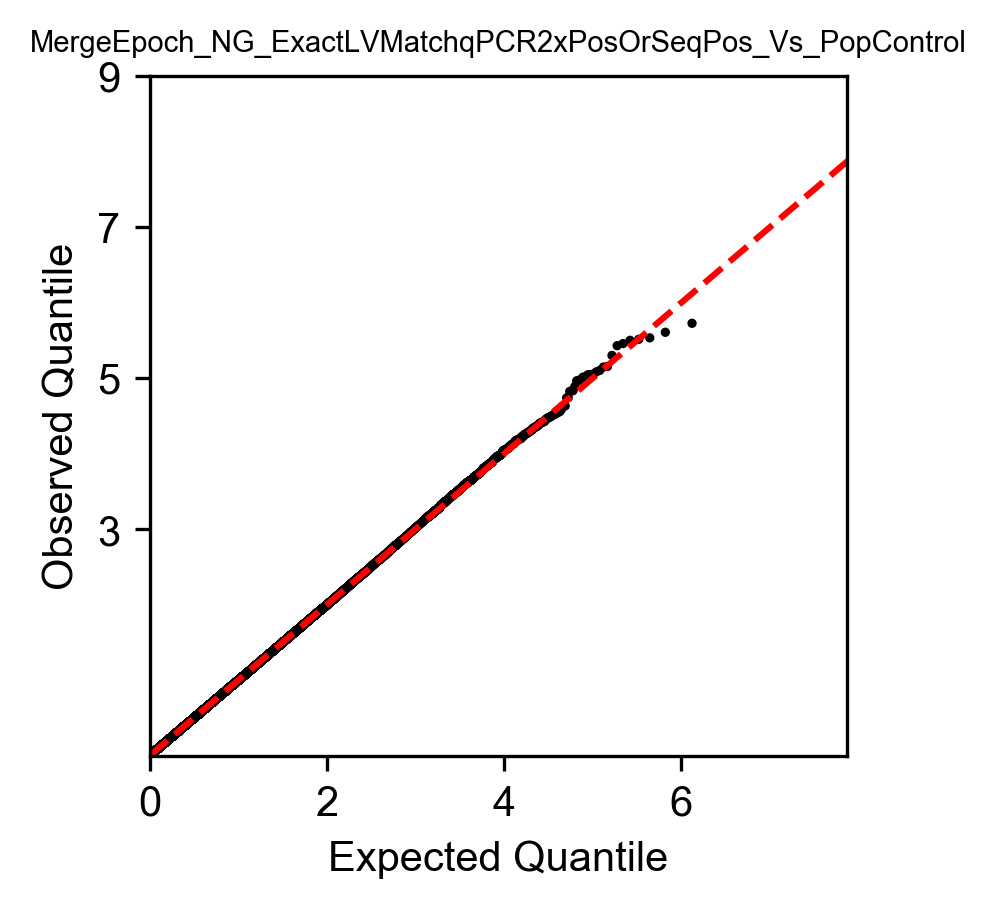

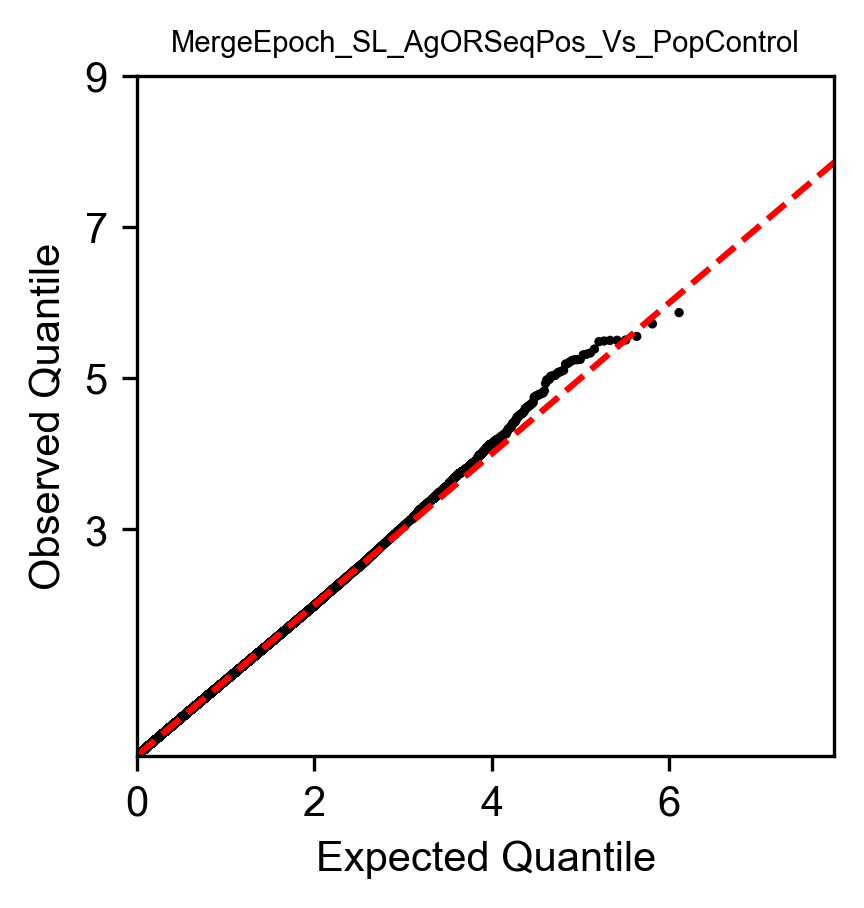

In [94]:
for p in phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=300)
    ax = qqplot(res[p]['PVAL'].values.reshape(-1),
       fill_dens=0.2, 
       title=p, ax=ax)
    ax.set_yticks([3,5,7,9])
    ax.set_title(p, fontsize=7)

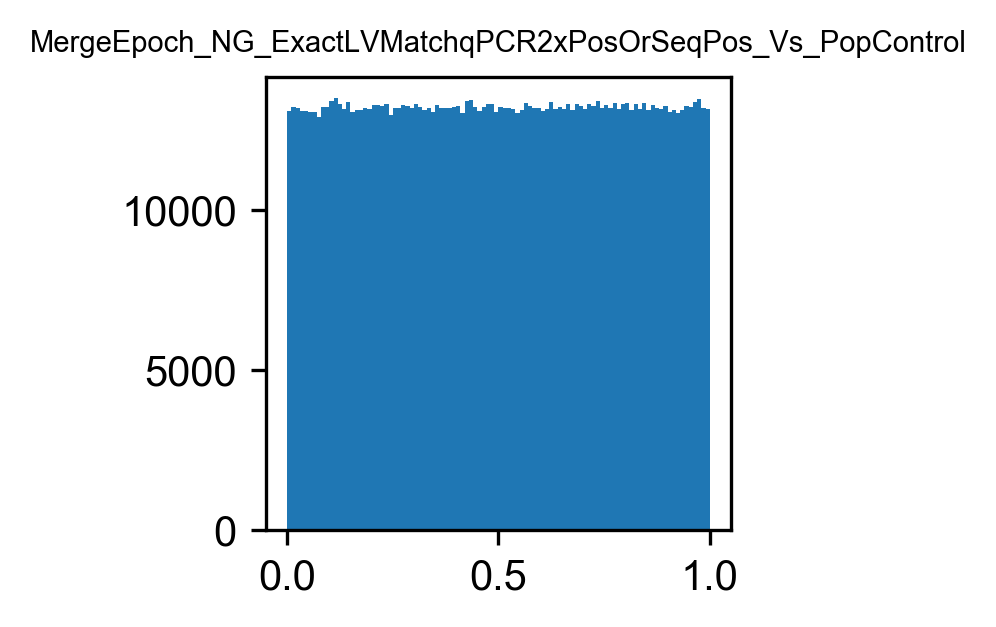

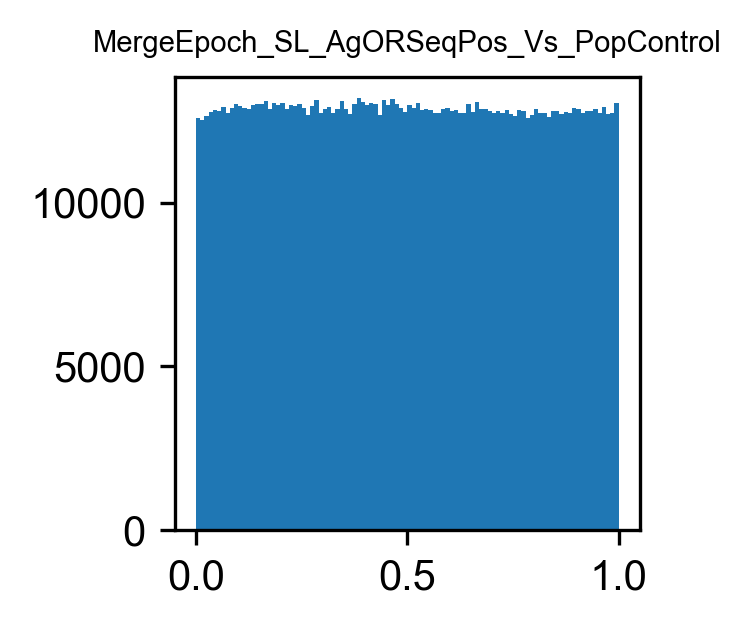

In [95]:
for p in phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=300)
    _ = ax.hist(res[p]['PVAL'], bins=100)
    _ = ax.set_title(p, fontsize=7)

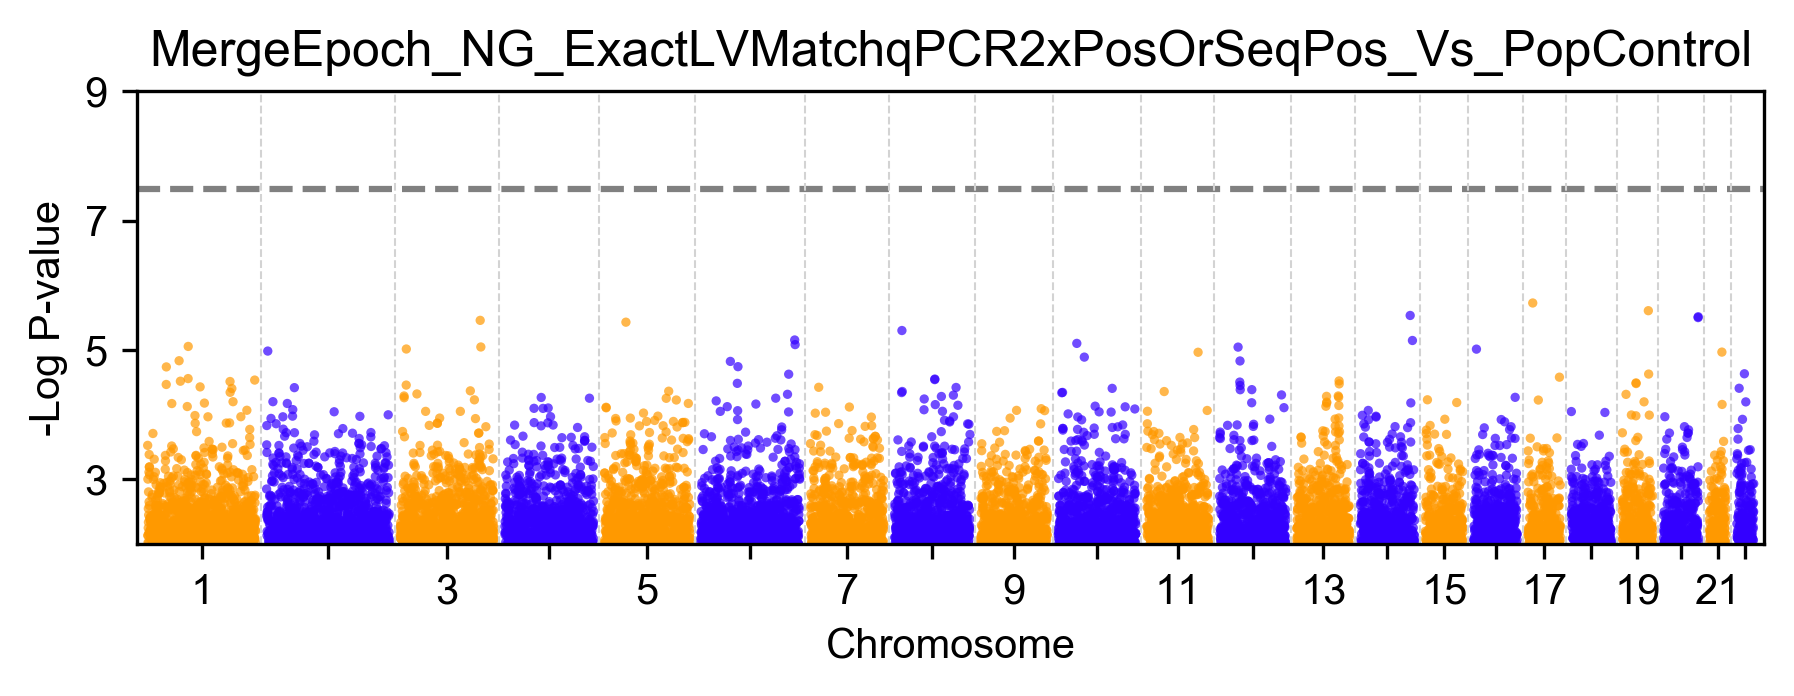

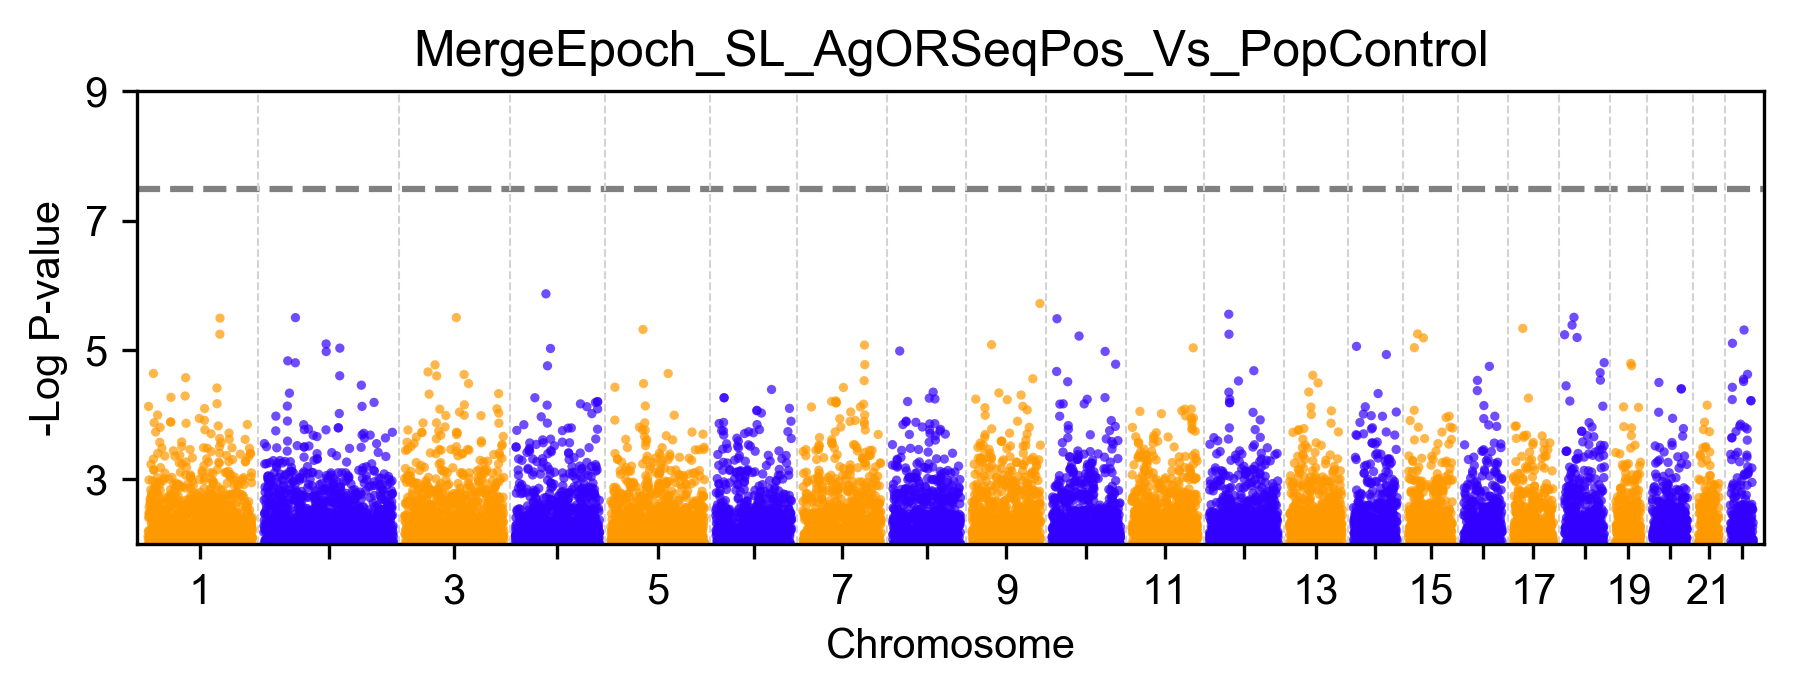

In [96]:
#chroms = [str(x) for x in range(1,23)]+['X'] # for some reason, no X
chroms = [str(x) for x in range(1,23)]
chrlist = []
for i in range(len(chroms)):
    if (i % 2) == 0:
        chrlist.append(chroms[i])
    else:
        chrlist.append('')

xlabel='CHR'
for p in phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(7,2), dpi=300)
    
    ind = ~res[p]['PVAL'].isnull()
    P = res[p].loc[ind,'PVAL'].values
    logP = -1*np.log10(P)
    bp = res[p].loc[ind,'POS'].values
    chrs = res[p].loc[ind, 'CHR'].astype(str).values
    manhattan(bp, chrs, P=None, minusLogP=logP, ax=ax, colors=['#ff9900', '#3300ff'],
             chrlist=chroms, chrlabels=chrlist, plotheight=None, cut=2, dotsize=5, spacer=100,
             xlabel='', title=p)
    xlim = ax.get_xlim()
    ax.hlines(y=-1*np.log10(3.24e-8), xmin=xlim[0], xmax=xlim[1], linestyle='--', color='gray')
    ax.set_xlim()
    ax.set_yticks([3,5,7,9])
    ax.set_xlabel('Chromosome')

## Prepare Imputed GWAS

In [125]:
cmd = 'gsutil -m cp gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/OmniH3Merged_PrePost2016* %s/' % imputeddata
print(cmd)
!{cmd}

gsutil -m cp gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/OmniH3Merged_PrePost2016* ../../data/tmp/GWAS/data/imputed/
Copying gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr1.log...
Copying gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr1.pgen...
Copying gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr1.psam...
Copying gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr1.pvar...
Copying gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr10.log...
Copying gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr10.pgen...
Copying gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr10.pvar...

In [98]:
impbase = os.path.join(imputeddata, 'OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr{c}')

In [99]:
chroms = [str(x) for x in range(1,23)] + ['X']
praw_adats = []
for p in phenotypes:
    pdir = os.path.join(resdir, p)
    pdir_impdata = os.path.join(pdir, 'imputed_data')
    if not os.path.exists(pdir_impdata): os.mkdir(pdir_impdata)
    pdir_imp_dosage_data = os.path.join(pdir, 'imputed_dosage_data')
    sampfn = os.path.join(pdir, 'samples.txt')
    samps = pd.read_csv(sampfn, sep='\t', header=None)
    sampfn_fix = sampfn.replace('.txt', '_noFID.txt')
    samps[1].to_csv(sampfn_fix, index=False, header=False)
    for c in chroms:
        inv = impbase.format(c=c)
        outfn = os.path.join(pdir_impdata, inv.split('/')[-1].split('chr')[0] +'{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.mac_{mac}.chr{c}'.format(p=p, maf=maf, hwe=hwe, geno=geno, c=c, mac=mac))

        filt_cmd = 'plink2 --export vcf vcf-dosage=DS-force id-paste=iid bgz --pfile {inv} --keep {samples} --keep-allele-order --maf {maf} --hwe {hwe} --geno {geno} --mac {mac} --out {out} --set-all-var-ids @:#[b37]\$r,\$a'.format(inv=inv, samples=sampfn_fix, out=outfn, maf=maf, hwe=hwe, geno=geno, mac=mac)
        print(filt_cmd)
        !{filt_cmd}
        print('--------------------------\n\n\n\n\n\n\n')


plink2 --export vcf vcf-dosage=DS-force id-paste=iid bgz --pfile ../../data/tmp/GWAS/data/imputed/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr1 --keep ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/samples_noFID.txt --keep-allele-order --maf 1e-2 --hwe 1e-6 --geno 5e-2 --mac 25 --out ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.chr1 --set-all-var-ids @:#[b37]\$r,\$a
PLINK v2.00a3LM 64-bit Intel (1 Jul 2021)      www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPos

In [100]:
remotedir = 'gs://popgen-gwas/data/analysis/results_20230804'

In [101]:
cpcmd = 'gsutil -m rsync -r %s %s' % (resdir, remotedir)
cpcmd

'gsutil -m rsync -r ../../data/tmp/GWAS/results_20230804 gs://popgen-gwas/data/analysis/results_20230804'

In [102]:
!{cpcmd}

Building synchronization state...
Starting synchronization...
Copying file://../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/Covar_Pheno_UnrelatedPCs.txt [Content-Type=text/plain]...
Copying file://../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.chr1.log [Content-Type=application/octet-stream]...
Copying file://../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.chr1.vcf.gz [Content-Type=text/vcard]...
Copying file://../../data/tmp/GWAS/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePo

In [108]:
#imputed gwas
scriptfn = 'gs://ebola-gwas-lbr/Code/run_GMMAT_premade_model_vcf_dosage.R' # score test
container = 'quay.io/dkotliar/gmmat_mkl:0.4'
ncores = 7
    
subcmdbase = '''dsub --project sabeti-ebola-gwas \
--name %s --min-ram 16 --min-cores 8 --boot-disk-size 600 --disk-size 1000 --zones "us-east1-b" \
--logging %s \
--image %s --ssh \
--input SCRIPT=%s \
--input NULLFILE=%s \
--input VCF_FILE=%s \
--output OUTPUT=%s \
--command '%s\''''   

cmd = 'Rscript --vanilla ${SCRIPT} ${NULLFILE} ${VCF_FILE} ${OUTPUT} %d' % (ncores)    
#need to update
impfnbase = 'OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.chr{c}.vcf.gz'
chroms = list([str(x) for x in range(1,23)]) + ['X']
#for p in phenotypes:
for p in phenotypes:
    pdir = '{base}/{p}'.format(base=remotedir, p=p)
    phenoresdir = os.path.join(pdir, 'results')
    rawgwasdir = os.path.join(phenoresdir, 'raw_gwas')

    covarstr = ''.join(covarmap[p])
    nulloutfile = os.path.join(rawgwasdir, "gmmat.%s.%s.nullmodel.rds" % (covarstr, p))
    
    logdir = os.path.join(phenoresdir, 'imputed_gwas_log')
    remote_resdir = os.path.join(phenoresdir, 'imputed_gwas')
    
    logbase = os.path.join(logdir, "{job-name}-{job-id}.log")    
    for c in chroms[1:]:
        vcfbase = os.path.join(pdir, 'imputed_data', impfnbase.format(c=c, p=p))
        outfile = os.path.join(remote_resdir, "gmmat.fromVCFdosage.%s.%s.%s.results.tsv" % (covarstr, p, c)) # score test
        name = '%s.%s' % (p, c)
        fullcmd = subcmdbase % (name,logbase,container,scriptfn, nulloutfile, vcfbase, outfile, cmd)
        print(fullcmd)
        !{fullcmd}

dsub --project sabeti-ebola-gwas --name MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.2 --min-ram 16 --min-cores 8 --boot-disk-size 600 --disk-size 1000 --zones "us-east1-b" --logging gs://popgen-gwas/data/analysis/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/imputed_gwas_log/{job-name}-{job-id}.log --image quay.io/dkotliar/gmmat_mkl:0.4 --ssh --input SCRIPT=gs://ebola-gwas-lbr/Code/run_GMMAT_premade_model_vcf_dosage.R --input NULLFILE=gs://popgen-gwas/data/analysis/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/raw_gwas/gmmat.SEXPCsH3.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.nullmodel.rds --input VCF_FILE=gs://popgen-gwas/data/analysis/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.chr2.vcf.gz --outpu

In [115]:
ngres = ! gsutil ls gs://popgen-gwas/data/analysis/results_20230804/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/imputed_gwas
len(ngres)

23

In [116]:
slres = ! gsutil ls gs://popgen-gwas/data/analysis/results_20230804/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/results/imputed_gwas
len(slres)

23

In [117]:
resdir

'../../data/tmp/GWAS/results_20230804'

In [118]:
covarmap

{'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl': ['SEX',
  'PCs',
  'H3'],
 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl': ['SEX', 'PCs', 'H3']}

In [119]:
phenotypes = ['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl',
 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']

In [ ]:
chroms = list([str(x) for x in range(1,23)]) + ['X']
imputedres = {}
for p in phenotypes:
    pdir = '{base}/{p}'.format(base=remotedir, p=p)
    phenoresdir = os.path.join(pdir, 'results')
    remoteresdir = os.path.join(phenoresdir, 'imputed_gwas')

    imputedres[p] = []
    covarstr = ''.join(covarmap[p])
    for c in chroms:
        # score test results
        outfn = os.path.join(remoteresdir, "gmmat.fromVCFdosage.%s.%s.%s.results.tsv" % (covarstr, p, c)) # score test
        imputedres[p].append(pd.read_csv(outfn, sep='\t'))
    imputedres[p] = pd.concat(imputedres[p], axis=0)

In [ ]:
for p in phenotypes:
    imputedres[p].index = imputedres[p]['SNP']
    print(imputedres[p].shape[0])

In [ ]:
imputedres[p].head()

In [ ]:
for p in phenotypes:
    print(p)
    display(imputedres[p].sort_values(by='PVAL').head(10))


In [ ]:
from gwas_plotting import qqplot

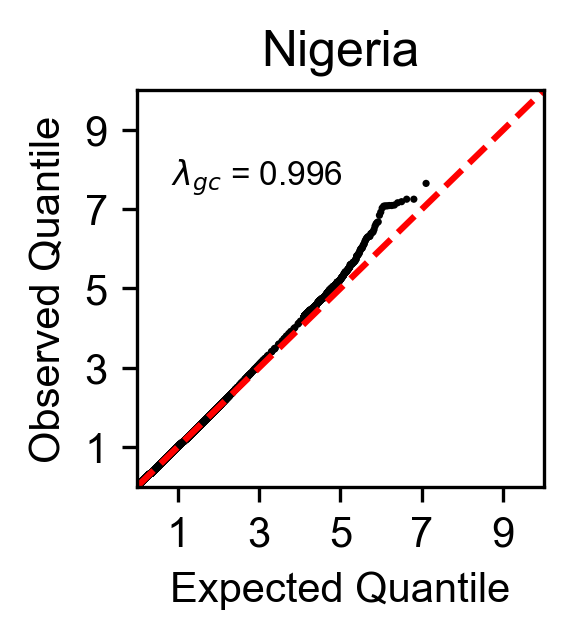

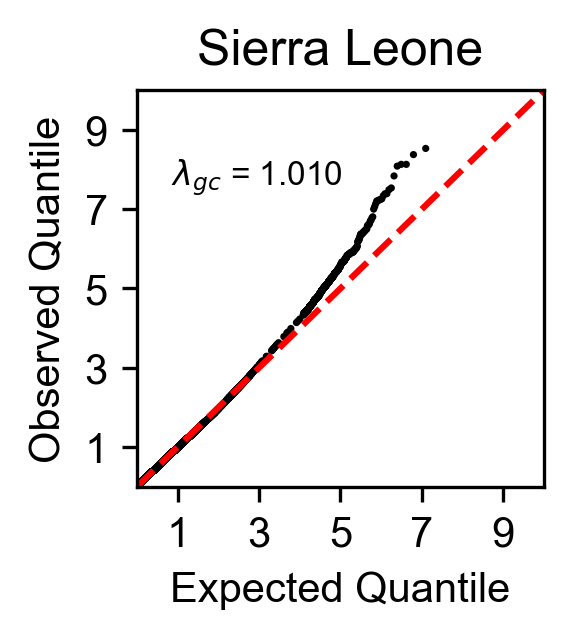

In [235]:
for p in phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(1.75,1.75), dpi=300)
    P = imputedres[p]['PVAL'].dropna().values.reshape(-1)
    ax = qqplot(P, num_top_points=1000, numsample=50000, fill_dens=0.2, title=title_map[p],ax=ax, dot_size=3, rasterized=True)
    
    if p == 'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl':
        ax.set_xticks([1,3,5,7,9])
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
        ax.set_xlim([0, 10])
    else:
        ax.set_xticks([1,3,5,7,9])
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
        ax.set_xlim([0, 10])
        
    ax.set_xlabel('Expected Quantile')
    ax.set_ylabel('Observed Quantile')
    
    gc = np.median(chi2.ppf(1-imputedres[p]['PVAL'].dropna(), df=1)) / chi2.ppf(.5, df=1)

    
    plt.figtext(.19, .7, '$\lambda_{gc}$ = %.3f' % gc, fontsize=8)

    
    outbase = "../../figures/" + p + "_qqplot_imp"
    plt.savefig(outbase + ".png", bbox_inches = 'tight')
    plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

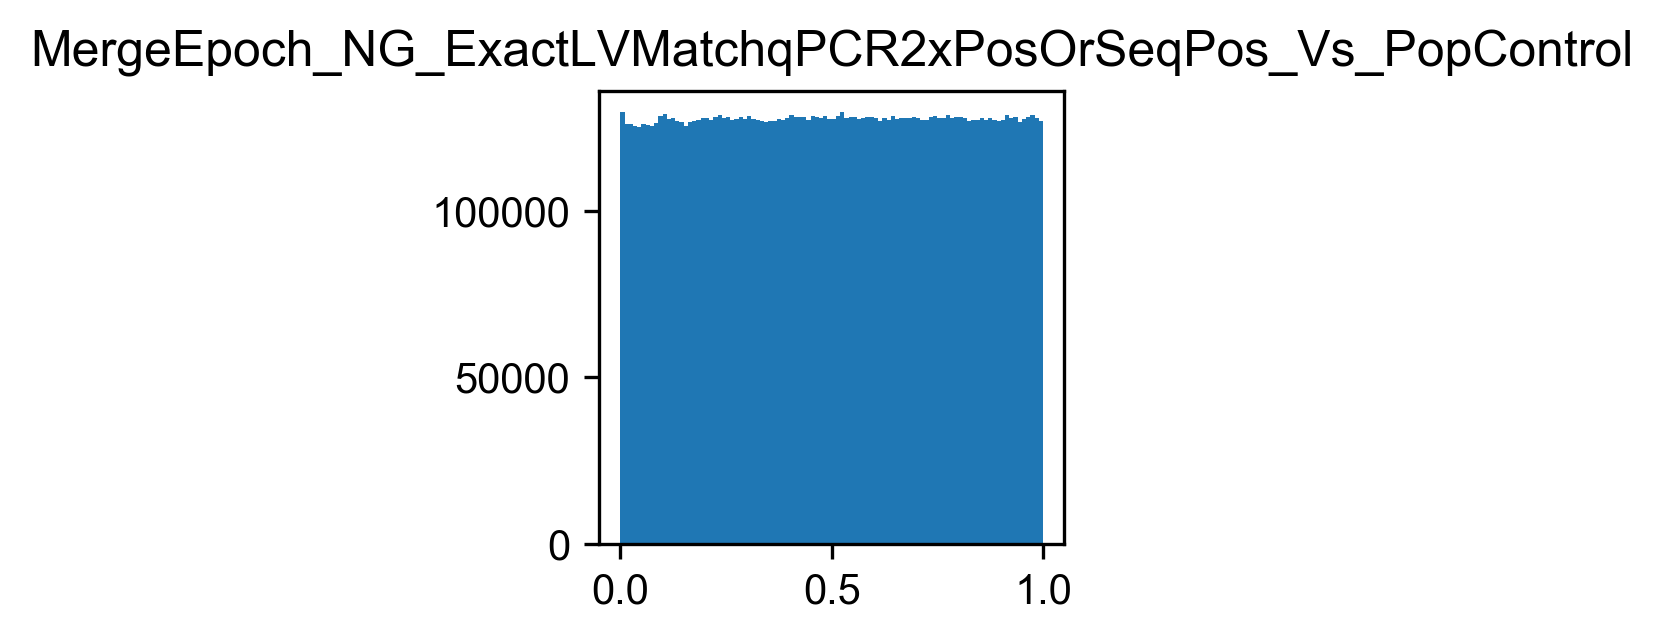

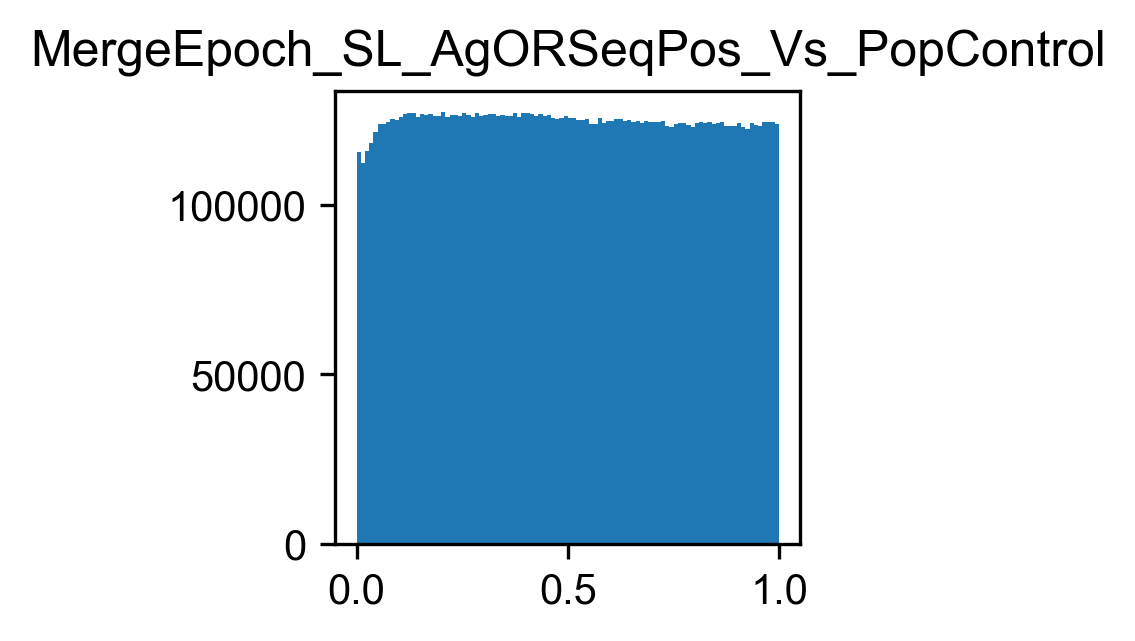

In [236]:
for p in phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=300)
    _ = ax.hist(imputedres[p]['PVAL'], bins=100)
    _ = ax.set_title(p)

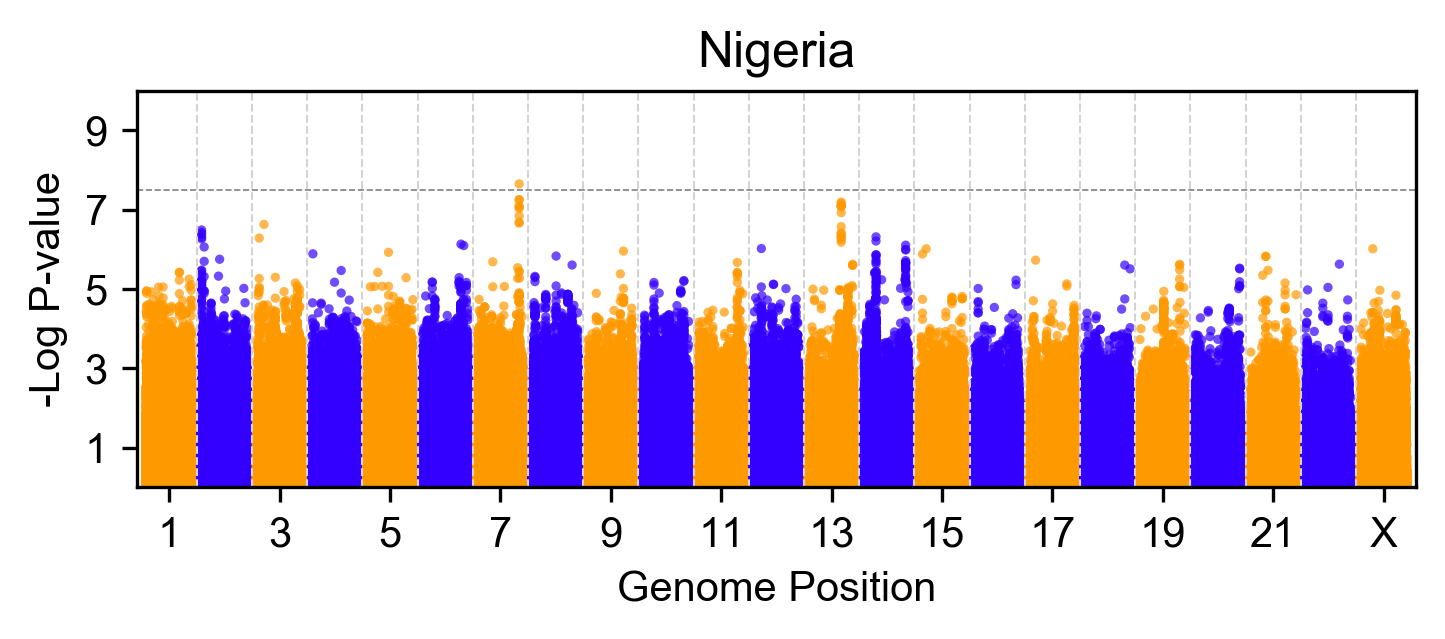

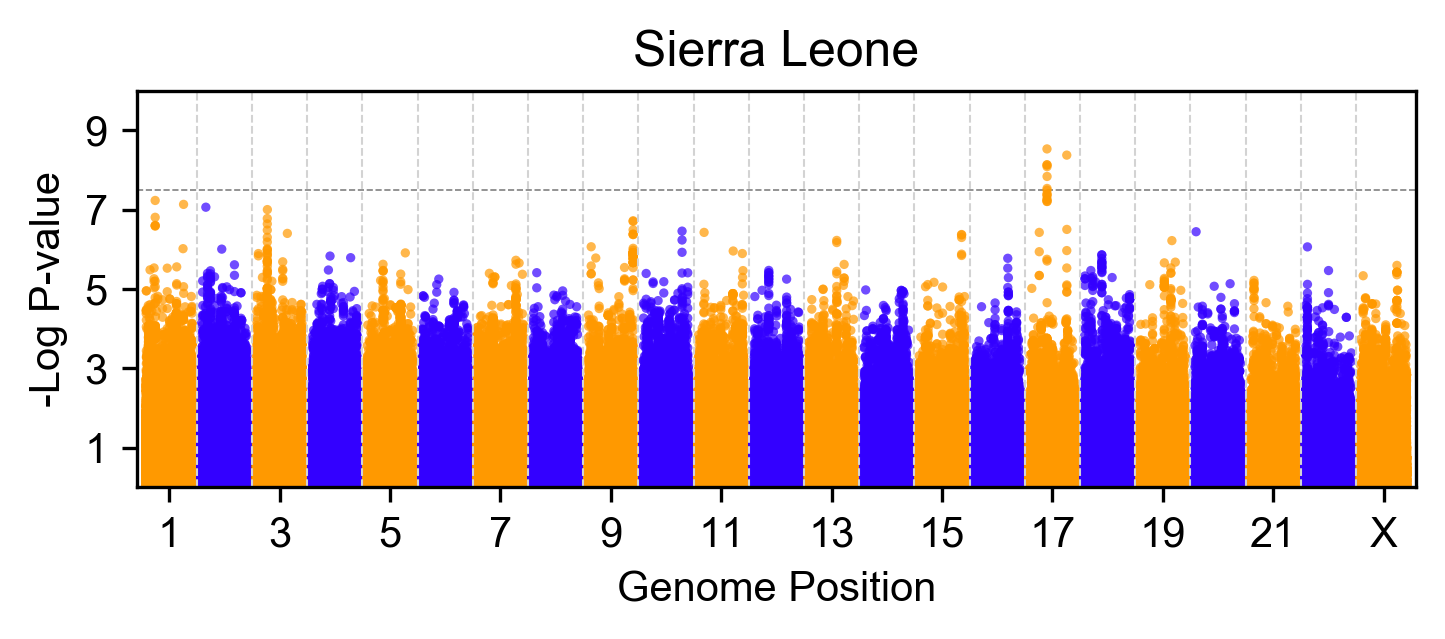

In [237]:
chroms = [str(x) for x in range(1,23)]+['X'] 
chrlist = []
for i in range(len(chroms)):
    if (i % 2) == 0:
        chrlist.append(chroms[i])
    else:
        chrlist.append('')

xlabel='CHR'

for p in phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(5.5,1.75), dpi=300)
    ind = ~imputedres[p]['PVAL'].isnull()
    P = imputedres[p].loc[ind,'PVAL'].values
    logP = -1*np.log10(P)
    bp = imputedres[p].loc[ind,'POS'].values
    chrs = imputedres[p].loc[ind, 'CHR'].astype(str).values
    manhattan_fixwidth(bp, chrs, P=None, minusLogP=logP, ax=ax, colors=['#ff9900', '#3300ff'],
             chrlist=chroms, chrlabels=chrlist, plotheight=None, cut=0, dotsize=5, spacer=.2,
             xlabel='', title='', only_altticks=True, rasterized=True)
    xlim = ax.get_xlim()
    ax.hlines(y=-1*np.log10(3.24e-8), xmin=xlim[0], xmax=xlim[1], linestyle='--', color='gray', lw=0.4, zorder=-10)

    if p == 'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl':
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
    else:
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
    
    ax.set_xlabel('Genome Position')
    ax.set_title(title_map[p])
    
    
    outbase = "../../figures/" + p + "_manhattan_imp"
    plt.savefig(outbase + ".png", bbox_inches = 'tight')
    plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

In [31]:
for p in phenotypes:
    imputedres[p].index = imputedres[p]['SNP'].values
    imputedres[p] = imputedres[p].sort_values(by='PVAL')


In [32]:
phenotypes = ['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl',
 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']

In [33]:
! ls ../../

analysis	   analysis_old_archive  data	  LICENSE     README.md
analysis_20200629  code			 figures  lost+found  tables


In [34]:
for p in phenotypes:
    outfn = '../../tables/SuppTable_FullAssociationStats_%s_casecontrol_20220828.tsv' % p.split('_')[1]
    print(outfn)
    imputedres[p].to_csv(outfn, sep='\t', index=False)

../../tables/SuppTable_FullAssociationStats_NG_casecontrol_20220828.tsv
../../tables/SuppTable_FullAssociationStats_SL_casecontrol_20220828.tsv


In [35]:
imputedres[p].head()

,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
"17:33192408[b37]C,G","17:33192408[b37]C,G",17,33192408,C,G,921,0.021716,0.019423,12.967183,4.772699,2.927974e-09
"17:68745251[b37]C,G","17:68745251[b37]C,G",17,68745251,C,G,921,0.023887,0.018910,11.919455,4.114331,4.194405e-09
"17:33266081[b37]C,A","17:33266081[b37]C,A",17,33266081,C,A,921,0.017372,0.023204,12.922882,4.995499,7.386526e-09
"17:33266080[b37]G,A","17:33266080[b37]G,A",17,33266080,G,A,921,0.017372,0.023204,12.922882,4.995499,7.386526e-09
"17:33371615[b37]A,G","17:33371615[b37]A,G",17,33371615,A,G,921,0.018458,0.029867,13.807199,5.736678,8.181191e-09


In [4]:
0.018910*(900*2)

34.038

In [3]:
921*(1-0.023887)

899.000073

## Run meta-analysis

In [36]:
in1 = '../../tables/SuppTable_FullAssociationStats_NG_casecontrol_20220828.tsv'
in2 = '../../tables/SuppTable_FullAssociationStats_SL_casecontrol_20220828.tsv'
metafn = '../../tables/SuppTable_FullAssociationStats_MetaAnalyzed_casecontrol_20220828.tsv'
cmd = 'Rscript ../../code/gwas_analysis/run_GMMAT_meta.R %s %s %s' % (in1, in2, metafn)
print(cmd)
!{cmd}

Rscript ../../code/gwas_analysis/run_GMMAT_meta.R ../../tables/SuppTable_FullAssociationStats_NG_casecontrol_20220828.tsv ../../tables/SuppTable_FullAssociationStats_SL_casecontrol_20220828.tsv ../../tables/SuppTable_FullAssociationStats_MetaAnalyzed_casecontrol_20220828.tsv


In [37]:
metafn = '../../tables/SuppTable_FullAssociationStats_MetaAnalyzed_casecontrol_20220828.tsv'


In [38]:
meta = pd.read_csv(metafn, sep='\t')
meta.head()

,SNP,A1,A2,N,AF,SCORE,VAR,PVAL
0,"7:146308575[b37]T,C",C,T,2519,0.011442,12.938194,5.490216,3.355867e-08
1,"7:146262071[b37]C,T",T,C,2519,0.015225,10.863187,7.391173,6.448410e-05
2,"7:146261329[b37]T,C",C,T,2519,0.015225,10.863187,7.391173,6.448410e-05
3,"13:88537883[b37]G,A",A,G,2519,0.020290,-11.910269,7.393135,1.184974e-05
4,"13:88530885[b37]G,A",A,G,2519,0.019988,-11.503725,7.359057,2.229222e-05


In [39]:
meta.sort_values(by='PVAL').head(10)

,SNP,A1,A2,N,AF,SCORE,VAR,PVAL
0,"7:146308575[b37]T,C",C,T,2519,0.011442,12.938194,5.490216,3.355867e-08
14,"7:146356694[b37]T,A",A,T,2519,0.011267,12.615363,5.304185,4.311299e-08
15,"7:146355677[b37]T,C",C,T,2519,0.011467,12.586309,5.367202,5.547398e-08
12759204,"1:209658594[b37]A,G",G,A,921,0.010965,8.516349,2.503290,7.338860e-08
12759205,"2:20782790[b37]C,G",G,C,921,0.009259,7.186658,1.802370,8.646207e-08
13,"7:146324580[b37]C,T",T,C,2519,0.010853,12.287055,5.273568,8.770476e-08
12759206,"3:42867552[b37]C,T",T,C,921,0.010965,8.116684,2.320879,9.937962e-08
12759207,"3:42536771[b37]T,A",A,T,921,0.014208,8.540762,2.663634,1.666870e-07
11,"7:146293176[b37]T,A",A,T,2519,0.011234,11.942224,5.255833,1.897376e-07
12759208,"3:42537236[b37]T,C",C,T,921,0.014738,8.502812,2.699897,2.282220e-07


In [40]:
meta.head(10)

,SNP,A1,A2,N,AF,SCORE,VAR,PVAL
0,"7:146308575[b37]T,C",C,T,2519,0.011442,12.938194,5.490216,3.355867e-08
1,"7:146262071[b37]C,T",T,C,2519,0.015225,10.863187,7.391173,6.448410e-05
2,"7:146261329[b37]T,C",C,T,2519,0.015225,10.863187,7.391173,6.448410e-05
3,"13:88537883[b37]G,A",A,G,2519,0.020290,-11.910269,7.393135,1.184974e-05
4,"13:88530885[b37]G,A",A,G,2519,0.019988,-11.503725,7.359057,2.229222e-05
5,"13:88534707[b37]G,C",C,G,2519,0.020823,-11.815949,7.437145,1.472458e-05
6,"13:88527425[b37]A,G",G,A,2519,0.020999,-11.721360,7.514230,1.902975e-05
7,"13:88528687[b37]G,A",A,G,2519,0.020999,-11.721360,7.514230,1.902975e-05
8,"7:146272410[b37]T,C",C,T,2519,0.015973,10.872078,7.458575,6.864591e-05
9,"7:146268583[b37]T,C",C,T,2519,0.015973,10.872078,7.458575,6.864591e-05


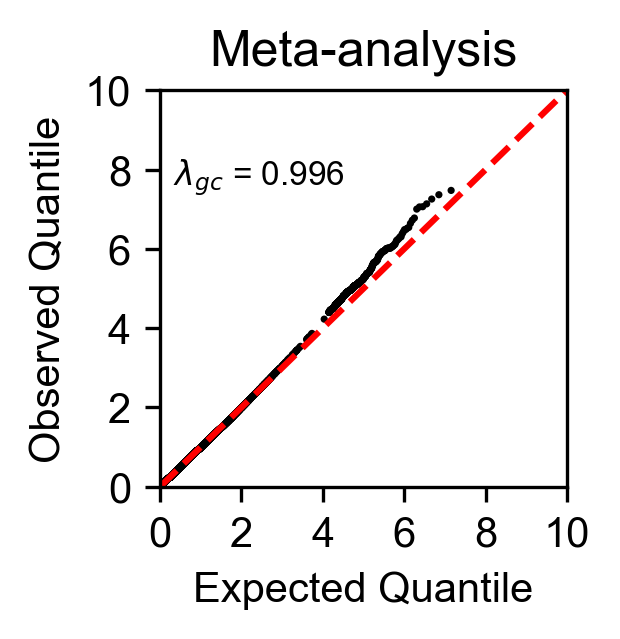

In [252]:
(fig,ax) = plt.subplots(1,1, figsize=(1.75,1.75), dpi=300)
P = meta['PVAL'].dropna().values.reshape(-1)
ax = qqplot(P, num_top_points=1000, numsample=50000, fill_dens=0.2, title='Meta-analysis',ax=ax, dot_size=3, rasterized=True)

ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_xticks([0, 2, 4, 6, 8, 10])

gc = np.median(chi2.ppf(1-meta['PVAL'].dropna(), df=1)) / chi2.ppf(.5, df=1)

plt.figtext(.15, .7, '$\lambda_{gc}$ = %.3f' % gc, fontsize=8)
ax.set_ylim([0, 10])

outbase = "../../figures/metaanalysis_casecontrol_qqplot_imp"
plt.savefig(outbase + ".png", bbox_inches = 'tight')
plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

In [246]:
meta['POS'] = meta['SNP'].apply(lambda x: x.split(':')[1].split('[')[0]).astype(float)
meta['CHR'] = meta['SNP'].apply(lambda x: x.split(':')[0])
meta['CHR'] = meta['CHR'].replace({'X':'23'}).astype(int)
meta = meta.sort_values(by=['CHR', 'POS'], ascending=True)
meta['CHR'] = meta['CHR'].replace({23:'X'}).astype(str)


In [247]:
meta = meta.rename(columns={'A2':'REF', 'A1':'ALT'})

In [248]:
meta = meta[['SNP', 'CHR', 'POS', 'REF', 'ALT', 'N',  'AF', 'SCORE', 'VAR', 'PVAL']]

In [249]:
meta.to_csv('../../tables/SuppTable_FullAssociationStats_MetaAnalyzed_casecontrol_fixCols.tsv', sep='\t', index=False)


In [38]:
meta = pd.read_csv('../../tables/SuppTable_FullAssociationStats_MetaAnalyzed_casecontrol_fixCols.tsv', sep='\t')


/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
meta.sort_values(by='PVAL').head(20)

,SNP,CHR,POS,REF,ALT,N,AF,SCORE,VAR,PVAL
6864873,"7:146308575[b37]T,C",7,146308575.0,T,C,2519,0.011442,12.938194,5.490216,3.355867e-08
6865130,"7:146356694[b37]T,A",7,146356694.0,T,A,2519,0.011267,12.615363,5.304185,4.311299e-08
6865123,"7:146355677[b37]T,C",7,146355677.0,T,C,2519,0.011467,12.586309,5.367202,5.547398e-08
872300,"1:209658594[b37]A,G",1,209658594.0,A,G,921,0.010965,8.516349,2.503290,7.338860e-08
1192181,"2:20782790[b37]C,G",2,20782790.0,C,G,921,0.009259,7.186658,1.802370,8.646207e-08
6864961,"7:146324580[b37]C,T",7,146324580.0,C,T,2519,0.010853,12.287055,5.273568,8.770476e-08
2504574,"3:42867552[b37]C,T",3,42867552.0,C,T,921,0.010965,8.116684,2.320879,9.937962e-08
2503104,"3:42536771[b37]T,A",3,42536771.0,T,A,921,0.014208,8.540762,2.663634,1.666870e-07
6864805,"7:146293176[b37]T,A",7,146293176.0,T,A,2519,0.011234,11.942224,5.255833,1.897376e-07
2503105,"3:42537236[b37]T,C",3,42537236.0,T,C,921,0.014738,8.502812,2.699897,2.282220e-07


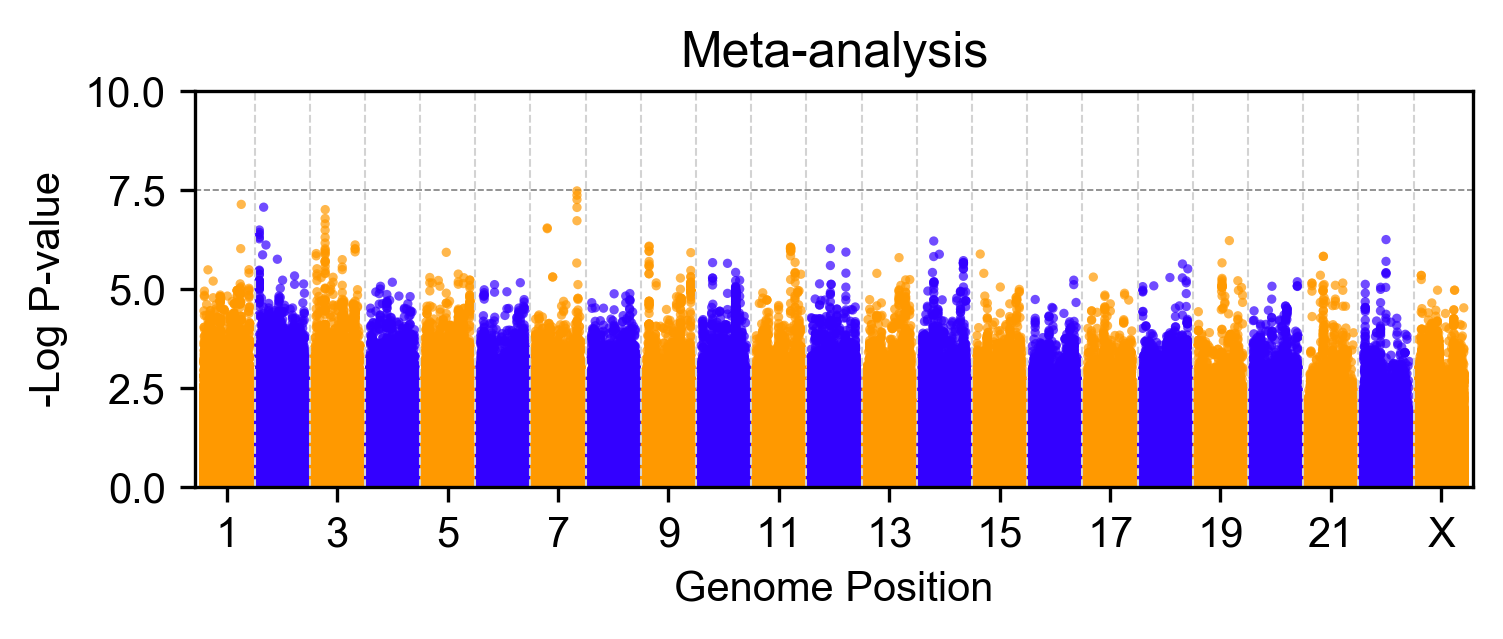

In [251]:
chroms = [str(x) for x in range(1,23)]+['X'] 
chrlist = []
for i in range(len(chroms)):
    if (i % 2) == 0:
        chrlist.append(chroms[i])
    else:
        chrlist.append('')

xlabel='CHR'

(fig,ax) = plt.subplots(1,1, figsize=(5.5,1.75), dpi=300)
ind = ~meta['PVAL'].isnull()
P = meta.loc[ind,'PVAL'].values
logP = -1*np.log10(P)
bp = meta.loc[ind,'POS'].values
chrs = meta.loc[ind, 'CHR'].astype(str).values
manhattan_fixwidth(bp, chrs, P=None, minusLogP=logP, ax=ax, colors=['#ff9900', '#3300ff'],
             chrlist=chroms, chrlabels=chrlist, plotheight=None, cut=0, dotsize=5, spacer=.2,
             xlabel='', title='', only_altticks=True, rasterized=True, linewidth=0.5)
xlim = ax.get_xlim()
ax.hlines(y=-1*np.log10(3.24e-8), xmin=xlim[0], xmax=xlim[1], linestyle='--', color='gray', lw=0.4, zorder=-10)

#ax.set_yticks([1,3,5,7,9])
#ax.set_ylim([0, 10])
    
ax.set_xlabel('Genome Position')
ax.set_title('Meta-analysis')
ax.set_ylim([0, 10])
    
    
outbase = "../../figures/metaanalysis_casecontrol_manhattan_imp"
plt.savefig(outbase + ".png", bbox_inches = 'tight')
plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

## Obtain Wald test results for significant variants

In [22]:
imputedres = {}
for p in ['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl', 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']:
    outfn = '../../tables/SuppTable_FullAssociationStats_%s_casecontrol_fixed20220311.tsv' % p.split('_')[1]
    print(outfn)
    imputedres[p] =pd.read_csv(outfn, sep='\t')
    imputedres[p].index = imputedres[p]['SNP']
    
imputedres[p].head()

../../tables/SuppTable_FullAssociationStats_NG_casecontrol_fixed20220311.tsv
../../tables/SuppTable_FullAssociationStats_SL_casecontrol_fixed20220311.tsv


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,,
"17:33192408[b37]C,G","17:33192408[b37]C,G",17,33192408,C,G,921,0.021716,0.019423,12.967183,4.772699,2.927974e-09
"17:68745251[b37]C,G","17:68745251[b37]C,G",17,68745251,C,G,921,0.023887,0.018910,11.919455,4.114331,4.194405e-09
"17:33266081[b37]C,A","17:33266081[b37]C,A",17,33266081,C,A,921,0.017372,0.023204,12.922882,4.995499,7.386526e-09
"17:33266080[b37]G,A","17:33266080[b37]G,A",17,33266080,G,A,921,0.017372,0.023204,12.922882,4.995499,7.386526e-09
"17:33371615[b37]A,G","17:33371615[b37]A,G",17,33371615,A,G,921,0.018458,0.029867,13.807199,5.736678,8.181191e-09


In [23]:
(imputedres['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl']['PVAL']<3.24e-8).sum()

1

In [24]:
(imputedres['MergeEpoch_SL_AgORSeqPos_Vs_PopControl']['PVAL']<3.24e-8).sum()

8

In [25]:
imputedres['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'].sort_values(by='PVAL').head(10)

,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,,
"7:146308575[b37]T,C","7:146308575[b37]T,C",7,146308575,T,C,1598,0.007509,0.010404,9.256584,2.739158,2.232223e-08
"7:146262071[b37]C,T","7:146262071[b37]C,T",7,146262071,C,T,1598,0.010013,0.008850,8.283163,2.325810,5.592414e-08
"7:146261329[b37]T,C","7:146261329[b37]T,C",7,146261329,T,C,1598,0.010013,0.008850,8.283163,2.325810,5.592414e-08
"13:88537883[b37]G,A","13:88537883[b37]G,A",13,88537883,G,A,1598,0.006884,0.017958,-9.448072,3.054910,6.459139e-08
"13:88530885[b37]G,A","13:88530885[b37]G,A",13,88530885,G,A,1598,0.001877,0.017241,-9.259342,2.946333,6.877159e-08
"13:88534707[b37]G,C","13:88534707[b37]G,C",13,88534707,G,C,1598,0.003755,0.018844,-9.454526,3.099244,7.853394e-08
"13:88527425[b37]A,G","13:88527425[b37]A,G",13,88527425,A,G,1598,0.002503,0.018821,-9.443902,3.098105,8.076287e-08
"13:88528687[b37]G,A","13:88528687[b37]G,A",13,88528687,G,A,1598,0.002503,0.018821,-9.443902,3.098105,8.076287e-08
"7:146272410[b37]T,C","7:146272410[b37]T,C",7,146272410,T,C,1598,0.010013,0.008850,8.230506,2.356303,8.239471e-08


In [26]:
imputedres['MergeEpoch_SL_AgORSeqPos_Vs_PopControl'].sort_values(by='PVAL').head(10)

,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,,
"17:33192408[b37]C,G","17:33192408[b37]C,G",17,33192408,C,G,921,0.021716,0.019423,12.967183,4.772699,2.927974e-09
"17:68745251[b37]C,G","17:68745251[b37]C,G",17,68745251,C,G,921,0.023887,0.018910,11.919455,4.114331,4.194405e-09
"17:33266081[b37]C,A","17:33266081[b37]C,A",17,33266081,C,A,921,0.017372,0.023204,12.922882,4.995499,7.386526e-09
"17:33266080[b37]G,A","17:33266080[b37]G,A",17,33266080,G,A,921,0.017372,0.023204,12.922882,4.995499,7.386526e-09
"17:33371615[b37]A,G","17:33371615[b37]A,G",17,33371615,A,G,921,0.018458,0.029867,13.807199,5.736678,8.181191e-09
"17:33410168[b37]C,T","17:33410168[b37]C,T",17,33410168,C,T,921,0.028230,0.026816,13.316449,5.520693,1.448949e-08
"17:33381303[b37]C,T","17:33381303[b37]C,T",17,33381303,C,T,921,0.016287,0.029249,13.127021,5.601114,2.912327e-08
"17:33386505[b37]T,C","17:33386505[b37]T,C",17,33386505,T,C,921,0.019544,0.027132,12.902371,5.446155,3.225773e-08
"17:33339333[b37]C,T","17:33339333[b37]C,T",17,33339333,C,T,921,0.002172,0.032644,13.168468,5.756312,4.050879e-08


In [27]:
sigres = []
for p in ['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl', 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']:
    X = imputedres[p].loc[imputedres[p]['PVAL']<5e-7, :]
    X['phenotype'] = p
    sigres.append(X)
    
sigres = pd.concat(sigres, axis=0)

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
sigres = sigres.sort_values(by='PVAL')

In [29]:
sigres.to_csv('/mnt/disks/gwas/data/tmp/mpra_prediction/lead_variants.tsv', sep='\t')

In [43]:
controlvars = []
for i in sigres.index:
    af = sigres.loc[i,'AF']
    p = sigres.loc[i,'phenotype']
    chrom = sigres.loc[i,'CHR']
    pos = sigres.loc[i,'POS']
    ind = (imputedres[p]['CHR']==chrom) & (imputedres[p]['AF']> (af-.05*af) ) & (imputedres[p]['AF']< (af+.05*af) ) & (imputedres[p]['PVAL']>.3)
    idx = (imputedres[p].loc[ind, 'POS']-pos).abs().sort_values(ascending=True).index
    if len(idx)>500:
        idx = idx[:500]
    dat = imputedres[p].loc[idx,:]
    dat.loc[:,'Matched_Var'] = i
    controlvars.append(dat)

In [44]:
controlvars = pd.concat(controlvars, axis=0)

In [45]:
controlvars.head()

,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL,Matched_Var
SNP,,,,,,,,,,,,
"17:33208755[b37]T,C","17:33208755[b37]T,C",17,33208755,T,C,921,0.002172,0.020131,-0.627010,2.686986,0.702084,"17:33192408[b37]C,G"
"17:33209838[b37]G,A","17:33209838[b37]G,A",17,33209838,G,A,921,0.000000,0.019544,-0.734949,2.692950,0.654254,"17:33192408[b37]C,G"
"17:33210258[b37]G,A","17:33210258[b37]G,A",17,33210258,G,A,921,0.000000,0.019544,-0.726046,2.709855,0.659174,"17:33192408[b37]C,G"
"17:33153299[b37]C,T","17:33153299[b37]C,T",17,33153299,C,T,921,0.009772,0.019737,0.984284,3.316089,0.588842,"17:33192408[b37]C,G"
"17:33150038[b37]G,T","17:33150038[b37]G,T",17,33150038,G,T,921,0.009772,0.019737,0.994965,3.306628,0.584268,"17:33192408[b37]C,G"


In [46]:
controlvars.shape

(34000, 12)

In [47]:
controlvars.drop_duplicates('SNP').shape

(16709, 12)

In [49]:
controlvars = controlvars.drop_duplicates('SNP')

In [50]:
controlvars.to_csv('/mnt/disks/gwas/data/tmp/mpra_prediction/control_variants.tsv', sep='\t')

In [52]:
! gsutil cp gs://tond/sharing/gnomAD/malinois_predictions/gnomad.mpra_preds.v3.1.2.sites.chr17.vcf.gz .

Copying gs://tond/sharing/gnomAD/malinois_predictions/gnomad.mpra_preds.v3.1.2.sites.chr17.vcf.gz...
| [1 files][  1.6 GiB/  1.6 GiB]   99.2 MiB/s                                   
Operation completed over 1 objects/1.6 GiB.                                      


In [23]:
imputedres[p].loc[idx, :]

SNP         17:33208755[b37]T,C
CHR                          17
POS                    33208755
REF                           T
ALT                           C
N                           921
MISSRATE             0.00217155
AF                    0.0201306
SCORE                  -0.62701
VAR                     2.68699
PVAL                   0.702084
Name: 17:33208755[b37]T,C, dtype: object

In [21]:
sigres.loc[i, :]

SNP                             17:33192408[b37]C,G
CHR                                              17
POS                                        33192408
REF                                               C
ALT                                               G
N                                               921
MISSRATE                                  0.0217155
AF                                        0.0194229
SCORE                                       12.9672
VAR                                          4.7727
PVAL                                    2.92797e-09
phenotype    MergeEpoch_SL_AgORSeqPos_Vs_PopControl
Name: 17:33192408[b37]C,G, dtype: object

In [30]:
for p in ['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl', 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']:
    print(p, imputedres[p].shape[0])

MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl 12759204
MergeEpoch_SL_AgORSeqPos_Vs_PopControl 12484450


In [30]:
imputedres['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'].sort_values(by='PVAL').head()

,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,,
"7:146308575[b37]T,C","7:146308575[b37]T,C",7,146308575,T,C,1598,0.007509,0.010404,9.256584,2.739158,2.232223e-08
"7:146262071[b37]C,T","7:146262071[b37]C,T",7,146262071,C,T,1598,0.010013,0.008850,8.283163,2.325810,5.592414e-08
"7:146261329[b37]T,C","7:146261329[b37]T,C",7,146261329,T,C,1598,0.010013,0.008850,8.283163,2.325810,5.592414e-08
"13:88537883[b37]G,A","13:88537883[b37]G,A",13,88537883,G,A,1598,0.006884,0.017958,-9.448072,3.054910,6.459139e-08
"13:88530885[b37]G,A","13:88530885[b37]G,A",13,88530885,G,A,1598,0.001877,0.017241,-9.259342,2.946333,6.877159e-08


In [31]:
meta = pd.read_csv('../../tables/SuppTable_FullAssociationStats_MetaAnalyzed_casecontrol_fixCols.tsv', sep='\t')

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
meta.index = meta['SNP']
meta.head()

,SNP,CHR,POS,REF,ALT,N,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,
"1:723918[b37]G,A","1:723918[b37]G,A",1,723918.0,G,A,2519,0.088924,1.948268,27.820991,0.711851
"1:724169[b37]A,G","1:724169[b37]A,G",1,724169.0,A,G,2519,0.011496,0.544874,4.963342,0.806787
"1:725286[b37]G,A","1:725286[b37]G,A",1,725286.0,G,A,2519,0.027265,-3.050640,11.090980,0.359655
"1:726797[b37]T,C","1:726797[b37]T,C",1,726797.0,T,C,1598,0.014761,0.182889,2.811120,0.913139
"1:729940[b37]C,G","1:729940[b37]C,G",1,729940.0,C,G,2519,0.120654,-3.063424,40.500789,0.630256


In [33]:
snp = '7:146308575[b37]T,C'

merged = pd.concat([imputedres['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'].loc[snp, :],
           imputedres['MergeEpoch_SL_AgORSeqPos_Vs_PopControl'].loc[snp, :],
           meta.loc[snp, :]], axis=1).T
merged = merged.loc[:, imputedres['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'].columns]
merged['Cohort'] = ['NG', 'SL', 'Meta-analysis']
merged

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL,Cohort
"7:146308575[b37]T,C","7:146308575[b37]T,C",7,146308575,T,C,1598,0.00750939,0.0104035,9.25658,2.73916,2.23222e-08,NG
"7:146308575[b37]T,C","7:146308575[b37]T,C",7,146308575,T,C,921,0.0162866,0.013245,3.68161,2.75106,0.0264414,SL
"7:146308575[b37]T,C","7:146308575[b37]T,C",7,1.46309e+08,T,C,2519,NaN,0.0114424,12.9382,5.49022,3.35587e-08,Meta-analysis


In [34]:
snp = '17:33192408[b37]C,G'

merged = pd.concat([imputedres['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'].loc[snp, :],
           imputedres['MergeEpoch_SL_AgORSeqPos_Vs_PopControl'].loc[snp, :],
           meta.loc[snp, :]], axis=1).T
merged = merged.loc[:, imputedres['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'].columns]
merged['Cohort'] = ['NG', 'SL', 'Meta-analysis']
merged

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL,Cohort
"17:33192408[b37]C,G","17:33192408[b37]C,G",17,33192408,C,G,1598,0.0100125,0.0306574,1.21759,6.70195,0.638122,NG
"17:33192408[b37]C,G","17:33192408[b37]C,G",17,33192408,C,G,921,0.0217155,0.0194229,12.9672,4.7727,2.92797e-09,SL
"17:33192408[b37]C,G","17:33192408[b37]C,G",17,3.31924e+07,C,G,2519,NaN,0.0265498,14.1848,11.4746,2.82071e-05,Meta-analysis


In [35]:

snp = '17:68745251[b37]C,G'

merged = pd.concat([imputedres['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'].loc[snp, :],
           imputedres['MergeEpoch_SL_AgORSeqPos_Vs_PopControl'].loc[snp, :],
           meta.loc[snp, :]], axis=1).T
merged = merged.loc[:, imputedres['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'].columns]
merged['Cohort'] = ['NG', 'SL', 'Meta-analysis']
merged

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL,Cohort
"17:68745251[b37]C,G","17:68745251[b37]C,G",17,68745251,C,G,1598,0.0306633,0.0568108,-1.99613,11.588,0.557616,NG
"17:68745251[b37]C,G","17:68745251[b37]C,G",17,68745251,C,G,921,0.0238871,0.0189099,11.9195,4.11433,4.19441e-09,SL
"17:68745251[b37]C,G","17:68745251[b37]C,G",17,6.87453e+07,C,G,2519,NaN,0.0429535,9.92333,15.7024,0.0122717,Meta-analysis


In [36]:
imputedres['Meta-analysis'] = meta

In [37]:
thresh = 5e-7
phenotypes = ['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl', 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl', 'Meta-analysis']

In [38]:
sigvars = []
for p in phenotypes:
    sigvars += list(imputedres[p].loc[imputedres[p]['PVAL']<thresh, 'SNP'])

print(len(sigvars))
sigvars = list(set(sigvars))
sigvars = sorted(sigvars)
print(len(sigvars))
sigvars[:5]

86
70


['10:116424693[b37]A,C',
 '11:17439031[b37]A,G',
 '13:88517098[b37]G,A',
 '13:88521711[b37]C,T',
 '13:88527425[b37]A,G']

### Merge sigvars across chromosomes

In [117]:
resdir

'../../data/tmp/GWAS/results_20220311'

In [127]:
impbase

'../../data/tmp/GWAS/data/imputed/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr*'

In [128]:
impbase = os.path.join(imputeddata, 'OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr*')

In [130]:
chroms = [str(x) for x in range(1,23)] + ['X']
for p in phenotypes[:-1]:
    pdir = os.path.join(resdir, p)
    pdir_impdata = os.path.join(pdir, 'imputed_data')
    pdir_imp_dosage_data = os.path.join(pdir, 'imputed_dosage_data')
    sampfn = os.path.join(pdir, 'samples.txt')
    samps = pd.read_csv(sampfn, sep='\t', header=None)
    sampfn_fix = sampfn.replace('.txt', '_noFID.txt')
    samps[1].to_csv(sampfn_fix, index=False, header=False)
    mergebase = impbase.replace('*', '{c}')
    #mergebase = os.path.join(pdir_impdata, impbase.split('/')[-1].split('chr')[0] +'{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.chr{c}'.format(p=p, maf=maf, hwe=hwe, geno=geno, c='{c}'))
    mergefns = [mergebase.format(c=c) for c in chroms]
    mergelistfn = os.path.join(pdir_impdata, 'chrfilestomerge.txt')
    out = os.path.join(pdir_impdata, impbase.split('/')[-1].split('chr')[0] +'{p}.{c}'.format(p=p, c='allChroms.sigVarsForWald'))
    #out = mergebase.replace('chr{c}', 'allChroms.sigVarsForWald')
    varsfn = out +'.varsToTest.txt'
    open(varsfn,'w').write('\n'.join(sigvars))
    
    
    
    open(mergelistfn, 'w').write('\n'.join(mergefns))
    cmd = 'plink2 --make-pgen --pmerge-list {mlist} --out {out} --extract {varsfn} --keep {samps} --set-all-var-ids @:#[b37]\$r,\$a'.format(mlist=mergelistfn, out=out, varsfn=varsfn, samps=sampfn_fix)
    print(cmd)
    !{cmd}

    cmd = 'plink2 --hardy --pfile {out} --out {out}'.format(out=out)
    print(cmd)
    !{cmd}
    
    cmd = 'plink2 --freq --pfile {out} --out {out}'.format(out=out)
    print(cmd)
    !{cmd}

    cmd = 'plink2 --missing --pfile {out} --out {out}'.format(out=out)
    print(cmd)
    !{cmd}
    
    ## Removelarge duplicate file created that includes all ofthe SNPs together
    cmd = 'rm %s-merge.*' % out
    print(cmd)
    !{cmd}

    filt_cmd = 'plink2 --export vcf vcf-dosage=DS-force id-paste=iid bgz --pfile {out} --out {out}'.format(out=out)
    print(filt_cmd)
    !{filt_cmd}

plink2 --make-pgen --pmerge-list ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/chrfilestomerge.txt --out ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.allChroms.sigVarsForWald --extract ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.allChroms.sigVarsForWald.varsToTest.txt --keep ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/samples_noFID.txt --set-all-var-ids @:#[b37]\$r,\$a
PLINK v2.00a3LM 64-bit Intel (1 Jul 2021)      www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to

### Run the actual Wald test

In [ ]:
# run the case/control logistic regression with only genotyped (unimputed) variants
ncores = 15
rawbase= '%s/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped' % rawdata

covarmap = {
            'MergeEpoch_SL_AgORSeqPos_Vs_PopControl':['SEX', 'PCs', 'H3'],
            'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl':['SEX', 'PCs', 'H3']
            }

for p in phenotypes[:-1]:
    pdir = os.path.join(resdir, p)
    pdir_impdata = os.path.join(pdir, 'imputed_data')
    pdir_rawdata = os.path.join(pdir, 'raw_data')

    vcffn = os.path.join(pdir_impdata, impbase.split('/')[-1].split('chr')[0] +'{p}.{c}'.format(p=p, maf=maf, hwe=hwe, geno=geno, c='allChroms.sigVarsForWald.vcf.gz'))
    phenoresdir = os.path.join(pdir, 'results')
    impgwasdir = os.path.join(phenoresdir, 'imputed_gwas')    
    if not os.path.exists(impgwasdir):
        os.mkdir(impgwasdir)
    pdir_rel = os.path.join(pdir, 'rel')
    bedbase = os.path.join(pdir_rawdata, rawbase.split('/')[-1]+'.{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.bed'.format(p=p, maf=maf, hwe=hwe, geno=geno))
    phenofn = os.path.join(pdir, 'Covar_Pheno_UnrelatedPCs.txt')
    relfn = os.path.join(pdir_rel, os.path.basename(bedbase)[:-4] + '.rel.withids.tsv') 
    

    non_pc_covars = [x for x in covarmap[p] if x != 'PCs']
    pcstr = ' + '.join(['PC%d' % x for x in range(1,(num_pcs[p]+1))])
    formula = '{p} ~ {nonpcvars} + {pcvars}'.format(p=p, nonpcvars=' + '.join(non_pc_covars), pcvars=pcstr)
    formula = '"%s"' % formula
    covarstr = ''.join(covarmap[p])  

    outfile = os.path.join(impgwasdir, 'gmmat.WaldTest.fromVCFdosage.%s.%s.allChroms.sigVarsForWald.results.tsv' % (covarstr, p))

    cmd = 'Rscript --vanilla ../../code/gwas_analysis/run_GMMAT_fromDosage_Wald.R %s %s %s %s %s %d' % (phenofn, vcffn, relfn, formula, outfile,ncores)
    print(cmd)
    !{cmd}
    print('\n\n')

Rscript --vanilla ../../code/gwas_analysis/run_GMMAT_fromDosage_Wald.R ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/Covar_Pheno_UnrelatedPCs.txt ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.allChroms.sigVarsForWald.vcf.gz ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/rel/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.rel.withids.tsv "MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl ~ SEX + H3 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6" ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/imputed_gwas/gmmat.WaldTest.fromVCFdosage.SEXPCsH3.MergeEp

In [22]:
waldres = {}
for p in ['MergeEpoch_SL_AgORSeqPos_Vs_PopControl', 'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl']:
    print(p)
    pdir = os.path.join(resdir, p)
    impgwasdir = os.path.join(pdir, 'results', 'imputed_gwas')    
    covarstr = ''.join(covarmap[p])  
    outfile = os.path.join(impgwasdir, 'gmmat.WaldTest.fromVCFdosage.%s.%s.allChroms.sigVarsForWald.results.tsv' % (covarstr, p))
    waldres[p] = pd.read_csv(outfile, sep='\t')
    waldres[p].index = waldres[p]['SNP']
    display(waldres[p].sort_values(by='PVAL').head(10))

MergeEpoch_SL_AgORSeqPos_Vs_PopControl


,SNP,CHR,POS,REF,ALT,N,AF,BETA,SE,PVAL,converged
SNP,,,,,,,,,,,
"17:68745251[b37]C,G","17:68745251[b37]C,G",17,68745251,C,G,921,0.024240,2.274535,0.413052,3.657152e-08,True
"17:33192408[b37]C,G","17:33192408[b37]C,G",17,33192408,C,G,921,0.027416,1.952382,0.359425,5.573884e-08,True
"17:33371615[b37]A,G","17:33371615[b37]A,G",17,33371615,A,G,921,0.033632,1.748674,0.329278,1.092479e-07,True
"17:33266080[b37]G,A","17:33266080[b37]G,A",17,33266080,G,A,921,0.028610,1.839431,0.350774,1.572016e-07,True
"17:33266081[b37]C,A","17:33266081[b37]C,A",17,33266081,C,A,921,0.028610,1.839431,0.350774,1.572016e-07,True
"17:33410168[b37]C,T","17:33410168[b37]C,T",17,33410168,C,T,921,0.033279,1.757741,0.335966,1.677777e-07,True
"17:33386505[b37]T,C","17:33386505[b37]T,C",17,33386505,T,C,921,0.031813,1.747946,0.339843,2.698200e-07,True
"17:33381303[b37]C,T","17:33381303[b37]C,T",17,33381303,C,T,921,0.032302,1.706000,0.332852,2.968992e-07,True
"17:33339333[b37]C,T","17:33339333[b37]C,T",17,33339333,C,T,921,0.032682,1.710271,0.335742,3.505756e-07,True


MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl


,SNP,CHR,POS,REF,ALT,N,AF,BETA,SE,PVAL,converged
SNP,,,,,,,,,,,
"13:88521711[b37]C,T","13:88521711[b37]C,T",13,88521711,C,T,1598,0.021011,-3.834616,0.753564,3.606351e-07,True
"7:146261329[b37]T,C","7:146261329[b37]T,C",7,146261329,T,C,1598,0.011092,2.475167,0.491278,4.698683e-07,True
"7:146262071[b37]C,T","7:146262071[b37]C,T",7,146262071,C,T,1598,0.011092,2.475167,0.491278,4.698683e-07,True
"7:146293176[b37]T,A","7:146293176[b37]T,A",7,146293176,T,A,1598,0.011514,2.367592,0.473477,5.719954e-07,True
"3:27919217[b37]A,C","3:27919217[b37]A,C",3,27919217,A,C,1598,0.012078,2.615203,0.523080,5.744288e-07,True
"7:146308575[b37]T,C","7:146308575[b37]T,C",7,146308575,T,C,1598,0.012954,2.176113,0.435654,5.882184e-07,True
"7:146272410[b37]T,C","7:146272410[b37]T,C",7,146272410,T,C,1598,0.011217,2.437312,0.488491,6.054495e-07,True
"7:146268583[b37]T,C","7:146268583[b37]T,C",7,146268583,T,C,1598,0.011217,2.437312,0.488491,6.054495e-07,True
"13:88517098[b37]G,A","13:88517098[b37]G,A",13,88517098,G,A,1598,0.022074,-3.497535,0.704459,6.875380e-07,True


In [22]:
p = 'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'
snps = ['13:88521711[b37]C,T', '7:146261329[b37]T,C', '17:33192408[b37]C,G']
for s in snps:
    print(p,s, waldres[p].loc[s, 'BETA'], np.exp(waldres[p].loc[s, 'BETA']))

MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl 13:88521711[b37]C,T -3.83461606334495 0.02160963360811453
MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl 7:146261329[b37]T,C 2.47516713225931 11.883693095609921
MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl 17:33192408[b37]C,G 0.17689683011366397 1.1935079526952352


In [51]:
p = 'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'
snp = '7:146308575[b37]T,C'
print(p)
print('SNP: %s - ID %s' % (snp, 'rs181032423'))
print('OR %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA']), 4))
print('Lower CI %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA'] - 1.96*waldres[p].loc[snp, 'SE']), 4))
print('Upper CI %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA'] + 1.96*waldres[p].loc[snp, 'SE']), 4))

MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl
SNP: 7:146308575[b37]T,C - ID rs181032423
OR 8.812
Lower CI 3.752
Upper CI 20.697


In [52]:
p = 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl'
snp = '7:146308575[b37]T,C'
print(p)
print('SNP: %s - ID %s' % (snp, 'rs181032423'))
print('OR %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA']), 4))
print('Lower CI %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA'] - 1.96*waldres[p].loc[snp, 'SE']), 4))
print('Upper CI %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA'] + 1.96*waldres[p].loc[snp, 'SE']), 4))

MergeEpoch_SL_AgORSeqPos_Vs_PopControl
SNP: 7:146308575[b37]T,C - ID rs181032423
OR 3.101
Lower CI 1.123
Upper CI 8.559


In [53]:
p = 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl'
snp = '17:68745251[b37]C,G'
print(p)
print('SNP: %s - ID %s' % (snp, 'rs73397758'))
print('OR %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA']), 4))
print('Lower CI %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA'] - 1.96*waldres[p].loc[snp, 'SE']), 4))
print('Upper CI %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA'] + 1.96*waldres[p].loc[snp, 'SE']), 4))

MergeEpoch_SL_AgORSeqPos_Vs_PopControl
SNP: 17:68745251[b37]C,G - ID rs73397758
OR 9.723
Lower CI 4.327
Upper CI 21.848


In [54]:
p = 'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'
snp = '17:68745251[b37]C,G'
print(p)
print('SNP: %s - ID %s' % (snp, 'rs73397758'))
print('OR %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA']), 4))
print('Lower CI %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA'] - 1.96*waldres[p].loc[snp, 'SE']), 4))
print('Upper CI %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA'] + 1.96*waldres[p].loc[snp, 'SE']), 4))

MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl
SNP: 17:68745251[b37]C,G - ID rs73397758
OR 0.838
Lower CI 0.464
Upper CI 1.513


In [56]:
p = 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl'
snp = '17:33192408[b37]C,G'
print(p)
print('SNP: %s - ID %s' % (snp, 'rs143130878'))
print('OR %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA']), 4))
print('Lower CI %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA'] - 1.96*waldres[p].loc[snp, 'SE']), 4))
print('Upper CI %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA'] + 1.96*waldres[p].loc[snp, 'SE']), 4))

MergeEpoch_SL_AgORSeqPos_Vs_PopControl
SNP: 17:33192408[b37]C,G - ID rs143130878
OR 7.045
Lower CI 3.483
Upper CI 14.251


In [57]:
p = 'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'
snp = '17:33192408[b37]C,G'
print(p)
print('SNP: %s - ID %s' % (snp, 'rs143130878'))
print('OR %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA']), 4))
print('Lower CI %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA'] - 1.96*waldres[p].loc[snp, 'SE']), 4))
print('Upper CI %.3f' % np.round(np.exp(waldres[p].loc[snp, 'BETA'] + 1.96*waldres[p].loc[snp, 'SE']), 4))

MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl
SNP: 17:33192408[b37]C,G - ID rs143130878
OR 1.194
Lower CI 0.571
Upper CI 2.495
